In [1]:
# !pip install --user uproot
# !pip install --user vector 
# !pip install --user --upgrade awkward

# import sys
# sys.path.append("/eos/home-m/qintong/.local/lib/python2.7/site-packages")

In [2]:
# !pip list

In [3]:
import uproot3 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf

import vector
import awkward as ak  # at least version 1.2.0


2022-06-21 12:35:07.859514: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-06-21 12:35:07.875745: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-21 12:35:07.875763: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# loading the tree
# tree = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/MVAFILE_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]
# tree2 = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/MVAFILE_VBFHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

#tree = uproot3.open("/eos/user/q/qintong/SWAN_projects/Masters2021/Reco_data/DY1JetsToLL-LO_2018_tt_0.root")["ntuple"]
#tree2 = uproot3.open("/home/ql1821/Desktop/Research_Project/data/SV_GluGluHToTauTau_M-125_tt_2018.root")["ntuple"]
tree2 = uproot3.open("/home/ql1821/Desktop/Research_Project/data/SV_GluGluHToTauTauUncorrelatedDecay_Filtered_tt_2018.root")["ntuple"]

In [5]:
# define what variables are to be read into the dataframe

variables = [ 
            'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1',
            'pi2_px_1', 'pi2_py_1', 'pi2_pz_1', 'pi2_E_1',
            'pi3_px_1', 'pi3_py_1', 'pi3_pz_1', 'pi3_E_1', 
            'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2', 
            'pi2_px_2', 'pi2_py_2', 'pi2_pz_2', 'pi2_E_2', 
            'pi3_px_2', 'pi3_py_2', 'pi3_pz_2', 'pi3_E_2', 
            'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_1', 
            'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'pi0_E_2', 
            'phi_1','phi_2',
            'tau_decay_mode_1','tau_decay_mode_2',
            'gen_nu_p_1','gen_nu_px_1','gen_nu_py_1','gen_nu_pz_1','gen_nu_E_1',
            'gen_nu_p_2','gen_nu_px_2','gen_nu_py_2','gen_nu_pz_2','gen_nu_E_2',
            'gen_vis_p_1','gen_vis_px_1','gen_vis_py_1','gen_vis_pz_1','gen_vis_E_1',
            'gen_vis_p_2','gen_vis_px_2','gen_vis_py_2','gen_vis_pz_2','gen_vis_E_2',
            'met','m_sv',
            'aco_angle_1','aco_angle_2',
            'lead_pt_1','pt_vis','pt_1','pt_2',
            'eta_1','eta_2',
            'metx','mety',
            'ip_x_1','ip_y_1','ip_z_1',
            'ip_x_2','ip_y_2','ip_z_2',
            'sv_x_1','sv_y_1','sv_z_1',
            'sv_x_2','sv_y_2','sv_z_2',
            'Px_h','Py_h','Pz_h',
            'pt_h','eta_h',
            'svfit_px_1','svfit_py_1','svfit_pz_1','svfit_E_1',
            'svfit_eta_1',
            'svfit_phi_1',
            'svfit_px_2','svfit_py_2','svfit_pz_2','svfit_E_2',
            'svfit_eta_2',
            'svfit_phi_2',
            'gen_match_1','gen_match_2',
            'gen_nu_eta_1','gen_nu_eta_2',
            'gen_nu_phi_1','gen_nu_phi_2'
            #'wt_cp_sm', 'wt_cp_ps', 'wt_cp_mm','rand',
             ]

#df1 = tree.pandas.df(variables)

df2 = tree2.pandas.df(variables)

#combine VBF and ggH events

#df = pd.concat([df1,df2], ignore_index=True)
#print('{0}\n{1}\n{2}\n{3}'.format(A,B,C,D))
#df1['dm_1'],df1['dm_2'] = df1["tau_decay_mode_1"],df1["tau_decay_mode_2"]
df2['dm_1'],df2['dm_2'] = df2["tau_decay_mode_1"],df2["tau_decay_mode_2"]

### Preselection of data

* Select all hadronic decays, i.e. when dm = 0, 1, 10 in this sample. This means that at least one set of pion momentum is not 0.
* In this case, dm = 11 is also included. However, this channel is not considered in the analysis.

Therefore, the preselection will ignore all the events when all $\pi$ momentum components are zeros as well as when the dm == 11.

In [6]:
df_products = df2.iloc[:,0:32]
df_select = df2.loc[(df_products != 0).any(axis=1)]
df_select = df_select[(df_select['dm_1']<11)&(df_select['dm_2']<11)]
# df_select = df_select[(df_select['gen_nu_py_2']!=-9999)&(df_select['gen_nu_py_2']!=-9999)]
# df_select = df_select[(df_select['gen_nu_py_1']!=-9999)&(df_select['gen_nu_py_1']!=-9999)]

df_select = df_select[(df_select['gen_match_1']==5)&(df_select['gen_match_2']==5)]
l = df_select.index.to_numpy()

a = []
b = []
c = []

for i in l:
    a.append(df2['dm_1'][i]) 
    b.append(df2['dm_2'][i])

# df_select['tau_1'],df_select['tau_2']= [a,b]
# df_select['tau_2'] = b
# df_select['mass'] = c

In [7]:
df_select

,pi_px_1,pi_py_1,pi_pz_1,pi_E_1,pi2_px_1,pi2_py_1,pi2_pz_1,pi2_E_1,pi3_px_1,pi3_py_1,...,svfit_eta_2,svfit_phi_2,gen_match_1,gen_match_2,gen_nu_eta_1,gen_nu_eta_2,gen_nu_phi_1,gen_nu_phi_2,dm_1,dm_2
entry,,,,,,,,,,,,,,,,,,,,,
0,-18.843747,0.010897,-3.417199,19.151596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.75,0.296706,5,5,-0.210796,-0.784964,-3.020697,0.171586,1,10
2,48.772534,12.352636,-117.169222,127.514681,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.75,-1.483530,5,5,-1.603171,-1.744225,0.290155,-1.424891,1,10
4,5.249920,-12.394966,-22.458754,26.184192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.75,1.797689,5,5,-1.316307,-0.761706,-1.204498,1.728811,1,1
5,-52.894818,-16.907334,9.244566,56.295659,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.35,0.122173,5,5,0.193548,-0.375669,-2.769673,0.170350,0,0
6,-26.475319,5.052566,-19.440440,33.232832,-7.340141,1.650589,-5.755967,9.473792,-11.032240,2.281226,...,-0.15,-0.296706,5,5,-0.612113,-0.172669,2.907902,-0.332386,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1423616,35.384872,52.425885,-63.244626,89.445316,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.65,-2.530727,5,5,-0.714098,-0.706641,1.011611,-2.592570,0,0
1423617,38.293232,-24.689468,-2.295294,45.620492,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.05,2.391101,5,5,0.055971,1.054430,-0.588273,2.345651,0,10
1423618,-1.711885,33.581395,-73.949254,81.235166,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.75,-1.623156,5,5,-1.559544,-0.786645,1.580418,-1.554190,1,1


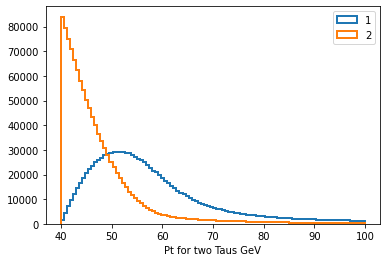

In [8]:
plt.hist(df_select['pt_1'],range = (40, 100),bins = 100,label='1',histtype = u'step',lw = 2)
plt.hist(df_select['pt_2'],range = (40, 100),bins = 100,label='2',histtype = u'step',lw = 2)
plt.xlabel('Pt for two Taus GeV')
plt.legend()

(array([  119.,   129.,   149.,   149.,   185.,   209.,   203.,   232.,
          262.,   336.,   363.,   392.,   431.,   438.,   491.,   568.,
          648.,   682.,   811.,   829.,   950.,  1099.,  1174.,  1394.,
         1580.,  1687.,  1939.,  2181.,  2529.,  2926.,  3432.,  3868.,
         4569.,  5548.,  6937.,  9150., 12951., 19930., 32628., 51598.,
        60291., 54171., 45407., 39622., 36026., 33809., 32456., 31398.,
        30988., 30355., 30977., 31572., 31759., 32732., 34346., 36396.,
        39505., 44515., 53800., 60042., 50983., 32983., 20063., 12791.,
         8943.,  6734.,  5326.,  4557.,  3740.,  3302.,  2841.,  2401.,
         2215.,  1942.,  1752.,  1532.,  1329.,  1218.,  1061.,   969.,
          825.,   752.,   649.,   635.,   536.,   522.,   451.,   431.,
          320.,   337.,   321.,   256.,   236.,   197.,   194.,   164.,
          147.,   130.,   120.,   114.]),
 array([-300., -294., -288., -282., -276., -270., -264., -258., -252.,
        -246., -240., -

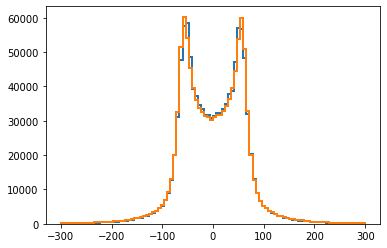

In [9]:
plt.hist(df_select['svfit_px_1'],bins = 100,range=(-300,300),histtype=u'step',lw = 2)
plt.hist(df_select['gen_vis_px_1']+df_select['gen_nu_px_1'],bins = 100,range=(-300,300),histtype=u'step',lw = 2)

In [10]:
df_c1 = df_select[(df_select['dm_1'] == 0) & (df_select['dm_2'] == 0)]
df_c2 = df_select[(df_select['dm_1'] == 1) & (df_select['dm_2'] == 0)]
df_c3 = df_select[(df_select['dm_1'] == 1) & (df_select['dm_2'] == 1)]
df_c4 = df_select[(df_select['dm_1'] == 1) & (df_select['dm_2'] == 10)]
df_c5 = df_select[(df_select['dm_1'] == 10) & (df_select['dm_2'] == 0)]
df_c6 = df_select[(df_select['dm_1'] == 10) & (df_select['dm_2'] == 10)]
df_c7 = df_select[(df_select['dm_1'] == 0) & (df_select['dm_2'] == 1)]
df_c8 = df_select[(df_select['dm_1'] == 0) & (df_select['dm_2'] == 10)]
df_c9 = df_select[(df_select['dm_1'] == 10) & (df_select['dm_2'] == 1)]

In [11]:
df_c1.index

Int64Index([      5,      46,      51,      62,      84,     114,     145,
                157,     167,     185,
            ...
            1423546, 1423549, 1423566, 1423567, 1423584, 1423592, 1423600,
            1423603, 1423615, 1423616],
           dtype='int64', name='entry', length=75442)

In [12]:
len(df_c1)+len(df_c2)+len(df_c3)+len(df_c4)+len(df_c5)+len(df_c6)+len(df_c7)+len(df_c8)+len(df_c9)

1142064

In [13]:
def combine_taus(n1,n2):
    ind = []
    for i in l:
        if (df_select['dm_1'][i] == n1) & (df_select['dm_2'][i] == n2):
                ind.append(i)
                df_c = df_select.iloc[ind]
    return df_c

In [14]:
def convert_vectors(df_taus,X,Y,Z,Energy,):
    A = df_taus[[X]].to_numpy()
    B = df_taus[[Y]].to_numpy()
    C = df_taus[[Z]].to_numpy()
    D = df_taus[[Energy]].to_numpy()
    A = [x for l in A for x in l]
    B = [x for l in B for x in l]
    C = [x for l in C for x in l]
    D = [x for l in D for x in l]

    v = []
    for i in range(len(A)):
        a = vector.obj(x=A[i], y=B[i], z=C[i], E=D[i])
        
        v.append(a)
    return v

In [15]:
def convert_vectors_gen(X,Y,Z,Energy,):
    A = df_select[[X]].to_numpy()
    B = df_select[[Y]].to_numpy()
    C = df_select[[Z]].to_numpy()
    D = df_select[[Energy]].to_numpy()
    A = [x for l in A for x in l]
    B = [x for l in B for x in l]
    C = [x for l in C for x in l]
    D = [x for l in D for x in l]

    v = []
    for i in range(len(A)):
        a = vector.obj(x=A[i], y=B[i], z=C[i], E=D[i])
        
        v.append(a)
    return v

In [16]:
# #(0,0)
# pi_v_c1 = convert_vectors(df_c1,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# #nu_v_c1 = convert_vectors(df_c1,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')

# pi_v2_c1 = convert_vectors(df_c1,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# #nu_v2_c1 = convert_vectors(df_c1,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(1,0)
# pi_v_c2 = convert_vectors(df_c2,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi0_v_c2 = convert_vectors(df_c2,'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_1')
# #nu_v_c2 = convert_vectors(df_c2,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')

# pi_v2_c2 = convert_vectors(df_c2,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# #nu_v2_c2 = convert_vectors(df_c2,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(1,1)
# pi_v_c3 = convert_vectors(df_c3,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi0_v_c3 = convert_vectors(df_c3,'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_1')
# #nu_v_c3 = convert_vectors(df_c3,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')

# pi_v2_c3 = convert_vectors(df_c3,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi0_v2_c3 = convert_vectors(df_c3,'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'pi0_E_2')
# #nu_v2_c3 = convert_vectors(df_c3,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(1,10)
# pi_v_c4 = convert_vectors(df_c4,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi0_v_c4 = convert_vectors(df_c4,'pi0_px_1', 'pi0_py_1', 'pi0_pz_1', 'pi0_E_1')
# #nu_v_c4 = convert_vectors(df_c4,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')

# pi_v2_c4 = convert_vectors(df_c4,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi2_v2_c4 = convert_vectors(df_c4,'pi2_px_2', 'pi2_py_2', 'pi2_pz_2', 'pi2_E_2')
# pi3_v2_c4 = convert_vectors(df_c4,'pi3_px_2', 'pi3_py_2', 'pi3_pz_2', 'pi3_E_2')
# #nu_v2_c4 = convert_vectors(df_c4,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(10,0)
# pi_v_c5 = convert_vectors(df_c5,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi2_v_c5 = convert_vectors(df_c5,'pi2_px_1', 'pi2_py_1', 'pi2_pz_1', 'pi2_E_1')
# pi3_v_c5 = convert_vectors(df_c5,'pi3_px_1', 'pi3_py_1', 'pi3_pz_1', 'pi3_E_1')
# #nu_v_c5 = convert_vectors(df_c5,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')


# pi_v2_c5 = convert_vectors(df_c5,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# #nu_v2_c5 = convert_vectors(df_c5,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(10,10)
# pi_v_c6 = convert_vectors(df_c6,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi2_v_c6 = convert_vectors(df_c6,'pi2_px_1', 'pi2_py_1', 'pi2_pz_1', 'pi2_E_1')
# pi3_v_c6 = convert_vectors(df_c6,'pi3_px_1', 'pi3_py_1', 'pi3_pz_1', 'pi3_E_1')
# #nu_v_c6 = convert_vectors(df_c6,'nu_px_1', 'nu_py_1', 'nu_pz_1', 'nu_E_1')

# pi_v2_c6 = convert_vectors(df_c6,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi2_v2_c6 = convert_vectors(df_c6,'pi2_px_2', 'pi2_py_2', 'pi2_pz_2', 'pi2_E_2')
# pi3_v2_c6 = convert_vectors(df_c6,'pi3_px_2', 'pi3_py_2', 'pi3_pz_2', 'pi3_E_2')
# #nu_v2_c6 = convert_vectors(df_c6,'nu_px_2', 'nu_py_2', 'nu_pz_2', 'nu_E_2')

# #(0,1)
# pi_v_c7 = convert_vectors(df_c7,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')

# pi_v2_c7 = convert_vectors(df_c7,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi0_v2_c7 = convert_vectors(df_c7,'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'pi0_E_2')

# #(0,10)
# pi_v_c8 = convert_vectors(df_c8,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')

# pi_v2_c8 = convert_vectors(df_c8,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi2_v2_c8 = convert_vectors(df_c8,'pi2_px_2', 'pi2_py_2', 'pi2_pz_2', 'pi2_E_2')
# pi3_v2_c8 = convert_vectors(df_c8,'pi3_px_2', 'pi3_py_2', 'pi3_pz_2', 'pi3_E_2')

# #(10,1)
# pi_v_c9 = convert_vectors(df_c9,'pi_px_1', 'pi_py_1', 'pi_pz_1', 'pi_E_1')
# pi2_v_c9 = convert_vectors(df_c9,'pi2_px_1', 'pi2_py_1', 'pi2_pz_1', 'pi2_E_1')
# pi3_v_c9 = convert_vectors(df_c9,'pi3_px_1', 'pi3_py_1', 'pi3_pz_1', 'pi3_E_1')

# pi_v2_c9 = convert_vectors(df_c9,'pi_px_2', 'pi_py_2', 'pi_pz_2', 'pi_E_2')
# pi0_v2_c9 = convert_vectors(df_c9,'pi0_px_2', 'pi0_py_2', 'pi0_pz_2', 'pi0_E_2')

# # #generated nutrinos
# # nu_1 = convert_vectors_gen('gen_nu_px_1','gen_nu_py_1', 'gen_nu_pz_1', 'gen_nu_E_1')
# # nu_2 = convert_vectors_gen('gen_nu_px_2','gen_nu_py_2', 'gen_nu_pz_2', 'gen_nu_E_2')

# # #generated visibles
# # vis_1 = convert_vectors_gen('gen_vis_px_1', 'gen_vis_py_1', 'gen_vis_pz_1', 'gen_vis_E_1')
# # vis_2 = convert_vectors_gen('gen_vis_px_2', 'gen_vis_py_2', 'gen_vis_pz_2', 'gen_vis_E_2')

In [17]:
def Tau_4m(*arg):
    out = []
    for i in range(len(arg[0])):
        
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in arg:
            total = total + v[i]
        out.append(total)
    return out

In [18]:
def getM(*arg):
    Energy = Tau_4m(*arg)
    x = range(0,2084)

    Tau1_p = []
    for i in range(len(Energy)):
        p_1 = (Energy[i].px, Energy[i].py, Energy[i].pz)
        Tau1_p.append(p_1)
    Tau1_p

    P = []
    for i in range(len(Tau1_p)):
        P.append(np.linalg.norm(Tau1_p[i]))

    return P

In [19]:
def compute_mass(*arg):
    out = np.empty(len(arg[1]), np.float64)
    for i in range(len(arg[1])):
        
        total = vector.obj(px=0.0, py=0.0, pz=0.0, E=0.0)
        for v in arg:
            total = total + v[i]
        out[i] = total.mass
    return out

In [20]:
def getM_compo(*arg):
    p = []
    for i in range(len(df_select[arg[0]])):
        p1 = 0
        for v in arg:
            p1 = p1+df_select[v].to_numpy()[i]
        p.append(p1)
        i=+1
    return p

In [21]:
def getM_compo_reco(df_tau,*arg):
    p = []
    for i in range(len(df_tau[arg[0]])):
        p1 = 0
        for v in arg:
            p1 = p1+df_tau[v].to_numpy()[i]
        p.append(p1)
        i=+1
    d = {'index':df_tau.index,
         'value':p}
    df = pd.DataFrame(data = d)
    df = df.set_index('index')
    return df


In [22]:
# n_gen = getM(nu_1,vis_1,nu_2,vis_2)
# n_gen_x = getM_compo('gen_nu_px_1','gen_nu_px_2','gen_vis_px_1','gen_vis_px_2')
# n_gen_y = getM_compo('gen_nu_py_1','gen_nu_py_2','gen_vis_py_1','gen_vis_py_2')
# n_gen_z = getM_compo('gen_nu_pz_1','gen_nu_pz_2','gen_vis_pz_1','gen_vis_pz_2')

In [23]:
# n1 = getM(pi_v_c1,pi_v2_c1)
# n2 = getM(pi_v_c2,pi0_v_c2,pi_v2_c2)
# n3 = getM(pi_v_c3,pi0_v_c3,pi_v2_c3,pi0_v2_c3)
# n4 = getM(pi_v_c4,pi0_v_c4,pi_v2_c4,pi2_v2_c4,pi3_v2_c4)
# n5 = getM(pi_v_c5,pi2_v_c5,pi3_v_c5,pi_v2_c5)
# n6 = getM(pi_v_c6,pi2_v_c6,pi3_v_c6,pi_v2_c6,pi2_v2_c6,pi3_v2_c6)
# n7 = getM(pi_v_c7,pi_v2_c7,pi0_v2_c7)
# n8 = getM(pi_v_c8,pi_v2_c8,pi2_v2_c8,pi3_v2_c8)
# n9 = getM(pi_v_c9,pi2_v_c9,pi3_v_c9,pi_v2_c9,pi0_v2_c9)

In [75]:
n1_x_1 = getM_compo_reco(df_c1,'pi_px_1')
n2_x_1 = getM_compo_reco(df_c2,'pi_px_1','pi0_px_1')
n3_x_1 = getM_compo_reco(df_c3,'pi_px_1','pi0_px_1')
n4_x_1 = getM_compo_reco(df_c4,'pi_px_1','pi0_px_1')
n5_x_1 = getM_compo_reco(df_c5,'pi_px_1','pi2_px_1','pi3_px_1')
n6_x_1 = getM_compo_reco(df_c6,'pi_px_1','pi2_px_1','pi3_px_1')
n7_x_1 = getM_compo_reco(df_c7,'pi_px_1')
n8_x_1 = getM_compo_reco(df_c8,'pi_px_1')
n9_x_1 = getM_compo_reco(df_c9,'pi_px_1','pi2_px_1','pi3_px_1')

n1_y_1 = getM_compo_reco(df_c1,'pi_py_1')
n2_y_1 = getM_compo_reco(df_c2,'pi_py_1','pi0_py_1')
n3_y_1 = getM_compo_reco(df_c3,'pi_py_1','pi0_py_1')
n4_y_1 = getM_compo_reco(df_c4,'pi_py_1','pi0_py_1')
n5_y_1 = getM_compo_reco(df_c5,'pi_py_1','pi2_py_1','pi3_py_1')
n6_y_1 = getM_compo_reco(df_c6,'pi_py_1','pi2_py_1','pi3_py_1')
n7_y_1 = getM_compo_reco(df_c7,'pi_py_1')
n8_y_1 = getM_compo_reco(df_c8,'pi_py_1')
n9_y_1 = getM_compo_reco(df_c9,'pi_py_1','pi2_py_1','pi3_py_1')

n1_z_1 = getM_compo_reco(df_c1,'pi_pz_1')
n2_z_1 = getM_compo_reco(df_c2,'pi_pz_1','pi0_pz_1')
n3_z_1 = getM_compo_reco(df_c3,'pi_pz_1','pi0_pz_1')
n4_z_1 = getM_compo_reco(df_c4,'pi_pz_1','pi0_pz_1')
n5_z_1 = getM_compo_reco(df_c5,'pi_pz_1','pi2_pz_1','pi3_pz_1')
n6_z_1 = getM_compo_reco(df_c6,'pi_pz_1','pi2_pz_1','pi3_pz_1')
n7_z_1 = getM_compo_reco(df_c7,'pi_pz_1')
n8_z_1 = getM_compo_reco(df_c8,'pi_pz_1')
n9_z_1 = getM_compo_reco(df_c9,'pi_pz_1','pi2_pz_1','pi3_pz_1')

n1_E_1 = getM_compo_reco(df_c1,'pi_E_1')
n2_E_1 = getM_compo_reco(df_c2,'pi_E_1','pi0_E_1')
n3_E_1 = getM_compo_reco(df_c3,'pi_E_1','pi0_E_1')
n4_E_1 = getM_compo_reco(df_c4,'pi_E_1','pi0_E_1')
n5_E_1 = getM_compo_reco(df_c5,'pi_E_1','pi2_E_1','pi3_E_1')
n6_E_1 = getM_compo_reco(df_c6,'pi_E_1','pi2_E_1','pi3_E_1')
n7_E_1 = getM_compo_reco(df_c7,'pi_E_1')
n8_E_1 = getM_compo_reco(df_c8,'pi_E_1')
n9_E_1 = getM_compo_reco(df_c9,'pi_E_1','pi2_E_1','pi3_E_1')

n1_x_2 = getM_compo_reco(df_c1,'pi_px_2')
n2_x_2 = getM_compo_reco(df_c2,'pi_px_2')
n3_x_2 = getM_compo_reco(df_c3,'pi_px_2','pi0_px_2')
n4_x_2 = getM_compo_reco(df_c4,'pi_px_2','pi2_px_2','pi3_px_2')
n5_x_2 = getM_compo_reco(df_c5,'pi_px_2')
n6_x_2 = getM_compo_reco(df_c6,'pi_px_2','pi2_px_2','pi3_px_2')
n7_x_2 = getM_compo_reco(df_c7,'pi_px_2','pi0_px_2')
n8_x_2 = getM_compo_reco(df_c8,'pi_px_2','pi2_px_2','pi3_px_2')
n9_x_2 = getM_compo_reco(df_c9,'pi_px_2','pi0_px_2')

n1_y_2 = getM_compo_reco(df_c1,'pi_py_2')
n2_y_2 = getM_compo_reco(df_c2,'pi_py_2')
n3_y_2 = getM_compo_reco(df_c3,'pi_py_2','pi0_py_2')
n4_y_2 = getM_compo_reco(df_c4,'pi_py_2','pi2_px_2','pi3_px_2')
n5_y_2 = getM_compo_reco(df_c5,'pi_py_2')
n6_y_2 = getM_compo_reco(df_c6,'pi_py_2','pi2_py_2','pi3_py_2')
n7_y_2 = getM_compo_reco(df_c7,'pi_py_2','pi0_py_2')
n8_y_2 = getM_compo_reco(df_c8,'pi_py_2','pi2_py_2','pi3_py_2')
n9_y_2 = getM_compo_reco(df_c9,'pi_py_2','pi0_py_2')

n1_z_2 = getM_compo_reco(df_c1,'pi_pz_2')
n2_z_2 = getM_compo_reco(df_c2,'pi_pz_2')
n3_z_2 = getM_compo_reco(df_c3,'pi_pz_2','pi0_pz_2')
n4_z_2 = getM_compo_reco(df_c4,'pi_pz_2','pi0_pz_2','pi3_pz_2')
n5_z_2 = getM_compo_reco(df_c5,'pi_pz_2')
n6_z_2 = getM_compo_reco(df_c6,'pi_pz_2','pi2_pz_2','pi3_pz_2')
n7_z_2 = getM_compo_reco(df_c7,'pi_pz_2','pi0_pz_2')
n8_z_2 = getM_compo_reco(df_c8,'pi_pz_2','pi2_pz_2','pi3_pz_2')
n9_z_2 = getM_compo_reco(df_c9,'pi_pz_2','pi0_pz_2')

n1_E_2 = getM_compo_reco(df_c1,'pi_E_2')
n2_E_2 = getM_compo_reco(df_c2,'pi_E_2')
n3_E_2 = getM_compo_reco(df_c3,'pi_E_2','pi0_E_2')
n4_E_2 = getM_compo_reco(df_c4,'pi_E_2','pi0_E_2','pi3_E_2')
n5_E_2 = getM_compo_reco(df_c5,'pi_E_2')
n6_E_2 = getM_compo_reco(df_c6,'pi_E_2','pi2_E_2','pi3_E_2')
n7_E_2 = getM_compo_reco(df_c7,'pi_E_2','pi0_E_2')
n8_E_2 = getM_compo_reco(df_c8,'pi_E_2','pi2_E_2','pi3_E_2')
n9_E_2 = getM_compo_reco(df_c9,'pi_E_2','pi0_E_2')

In [76]:
n_x_1 = pd.concat([n1_x_1,n2_x_1,n3_x_1,n4_x_1,n5_x_1,n6_x_1,n7_x_1,n8_x_1,n9_x_1]).sort_index()
n_y_1 = pd.concat([n1_y_1,n2_y_1,n3_y_1,n4_y_1,n5_y_1,n6_y_1,n7_y_1,n8_y_1,n9_y_1]).sort_index()
n_z_1 = pd.concat([n1_z_1,n2_z_1,n3_z_1,n4_z_1,n5_z_1,n6_z_1,n7_z_1,n8_z_1,n9_z_1]).sort_index()
n_E_1 = pd.concat([n1_E_1,n2_E_1,n3_E_1,n4_E_1,n5_E_1,n6_E_1,n7_E_1,n8_E_1,n9_E_1]).sort_index()

n_x_2 = pd.concat([n1_x_2,n2_x_2,n3_x_2,n4_x_2,n5_x_2,n6_x_2,n7_x_2,n8_x_2,n9_x_2]).sort_index()
n_y_2 = pd.concat([n1_y_2,n2_y_2,n3_y_2,n4_y_2,n5_y_2,n6_y_2,n7_y_2,n8_y_2,n9_y_2]).sort_index()
n_z_2 = pd.concat([n1_z_2,n2_z_2,n3_z_2,n4_z_2,n5_z_2,n6_z_2,n7_z_2,n8_z_2,n9_z_2]).sort_index()
n_E_2 = pd.concat([n1_E_2,n2_E_2,n3_E_2,n4_E_2,n5_E_2,n6_E_2,n7_E_2,n8_E_2,n9_E_2]).sort_index()

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        3.00000e+00, 7.00000e+00, 9.00000e+00, 1.40000e+01, 2.90000e+01,
        2.80000e+01, 3.50000e+01, 5.30000e+01, 7.50000e+01, 1.19000e+02,
        1.55000e+02, 2.11000e+02, 2.85000e+02, 3.91000e+02, 5.50000e+02,
        8.47000e+02, 1.21900e+03, 1.80300e+03, 2.61600e+03, 4.18700e+03,
        9.25700e+03, 2.65210e+04, 7.13480e+04, 1.01916e+05, 7.64310e+04,
        6.32260e+04, 5.54740e+04, 5.20890e+04, 4.98310e+04, 4.81890e+04,
        6.13500e+04, 4.96000e+04, 5.23130e+04, 5.46790e+04, 6.21480e+04,
        7.39830e+04, 1.01446e+05, 7.14410e+04, 2.66250e+04, 9.04900e+03,
        4.22700e+03, 2.57300e+03, 1.80100e+03, 1.14100e+03, 7.98000e+02,
        5.82000e+02, 4.01000e+02, 2.85000e+02, 1.81

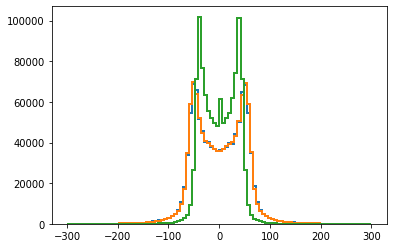

In [77]:
plt.hist(df_select['svfit_py_2'],bins = 100,range=(-300,300),histtype=u'step',lw = 2,label = 'svfit')
plt.hist(df_select['gen_vis_py_2']+df_select['gen_nu_py_2'],bins = 100,range=(-300,300),histtype=u'step',lw = 2,label = 'gen')
plt.hist(n_y_2,bins = 100,range=(-300,300),histtype=u'step',lw = 2,label = 'reco')

In [78]:
# #(0,0)
# n1_x = getM_compo_reco(df_c1,'pi_px_1','pi_px_2')
# #(1,0)
# n2_x = getM_compo_reco(df_c2,'pi_px_1','pi0_px_1','pi_px_2')
# #(1,1)
# n3_x = getM_compo_reco(df_c3,'pi_px_1','pi0_px_1','pi_px_2','pi0_px_2')
# #(1,10)
# n4_x = getM_compo_reco(df_c4,'pi_px_1','pi0_px_1','pi_px_2','pi2_px_2','pi3_px_2')
# #(10,0)
# n5_x = getM_compo_reco(df_c5,'pi_px_1','pi2_px_1','pi3_px_1','pi_px_2')
# #(10,10)
# n6_x = getM_compo_reco(df_c6,'pi_px_1','pi2_px_1','pi3_px_1','pi_px_2','pi2_px_2','pi3_px_2')
# #(0,1)
# n7_x = getM_compo_reco(df_c7,'pi_px_1','pi_px_2','pi0_px_2')
# #(0,10)
# n8_x = getM_compo_reco(df_c8,'pi_px_1','pi_px_2','pi2_px_2','pi3_px_2')
# #(10,1)
# n9_x = getM_compo_reco(df_c9,'pi_px_1','pi2_px_1','pi3_px_1','pi_px_2','pi0_px_2')

In [79]:
# n1_y = getM_compo_reco(df_c1,'pi_py_1','pi_py_2')
# n2_y = getM_compo_reco(df_c2,'pi_py_1','pi0_py_1','pi_py_2')
# n3_y = getM_compo_reco(df_c3,'pi_py_1','pi0_py_1','pi_py_2','pi0_py_2')
# n4_y = getM_compo_reco(df_c4,'pi_py_1','pi0_py_1','pi_py_2','pi2_py_2','pi3_py_2')
# n5_y = getM_compo_reco(df_c5,'pi_py_1','pi2_py_1','pi3_py_1','pi_py_2')
# n6_y = getM_compo_reco(df_c6,'pi_py_1','pi2_py_1','pi3_py_1','pi_py_2','pi2_py_2','pi3_py_2')
# n7_y = getM_compo_reco(df_c7,'pi_py_1','pi_py_2','pi0_py_2')
# n8_y = getM_compo_reco(df_c8,'pi_py_1','pi_py_2','pi2_py_2','pi3_py_2')
# n9_y = getM_compo_reco(df_c9,'pi_py_1','pi2_py_1','pi3_py_1','pi_py_2','pi0_py_2')

In [80]:
# n1_z = getM_compo_reco(df_c1,'pi_pz_1','pi_pz_2')
# n2_z = getM_compo_reco(df_c2,'pi_pz_1','pi0_pz_1','pi_pz_2')
# n3_z = getM_compo_reco(df_c3,'pi_pz_1','pi0_pz_1','pi_pz_2','pi0_pz_2')
# n4_z = getM_compo_reco(df_c4,'pi_pz_1','pi0_pz_1','pi_pz_2','pi2_pz_2','pi3_pz_2')
# n5_z = getM_compo_reco(df_c5,'pi_pz_1','pi2_pz_1','pi3_pz_1','pi_pz_2')
# n6_z = getM_compo_reco(df_c6,'pi_pz_1','pi2_pz_1','pi3_pz_1','pi_pz_2','pi2_pz_2','pi3_pz_2')
# n7_z = getM_compo_reco(df_c7,'pi_pz_1','pi_pz_2','pi0_pz_2')
# n8_z = getM_compo_reco(df_c8,'pi_pz_1','pi_pz_2','pi2_pz_2','pi3_pz_2')
# n9_z = getM_compo_reco(df_c9,'pi_pz_1','pi2_pz_1','pi3_pz_1','pi_pz_2','pi0_pz_2')

In [81]:
#n_reco = n1+n2+n3+n4+n5+n6+n7+n8+n9
# n_reco_x = n1_x+n2_x+n3_x+n4_x+n5_x+n6_x+n7_x+n8_x+n9_x
# n_reco_y = n1_y+n2_y+n3_y+n4_y+n5_y+n6_y+n7_y+n8_y+n9_y
# n_reco_z = n1_z+n2_z+n3_z+n4_z+n5_z+n6_z+n7_z+n8_z+n9_z
# # n_test = np.array(n_x_1)+np.array(n_x_2)
# #print(len(n_reco),len(n_gen))

In [82]:
# n1_reco = Tau_4m(pi_v_c1)
# n2_reco = Tau_4m(pi_v_c2,pi0_v_c2)
# n3_reco = Tau_4m(pi_v_c3,pi0_v_c3)
# n4_reco = Tau_4m(pi_v_c4,pi0_v_c4)
# n5_reco = Tau_4m(pi_v_c5,pi2_v_c5,pi3_v_c5)
# n6_reco = Tau_4m(pi_v_c6,pi2_v_c6,pi3_v_c6)
# n7_reco = Tau_4m(pi_v_c7)
# n8_reco = Tau_4m(pi_v_c8)
# n9_reco = Tau_4m(pi_v_c9,pi2_v_c9,pi3_v_c9)

#n_reco_vis = n1+n2+n3+n4+n5+n6+n7+n8+n9

#n_gen_reco_vis = getM(nu_1,n_reco_vis)

In [83]:
# plt.hist(n_gen_reco_vis,bins = 100,range=(0,520))
# plt.xlabel('ratio of momentums')
# #plt.title('Distribution of real and predicted $\\frac{P_{vis}}{P_{gen}}$')
# plt.title('momentum calculated by summing of the reco-visible and gen-neutrino 4-vectors')

In [84]:
#plt.hist(df_select['Py_h'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'svfit px')

# Regression

In [85]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras import Input, Model
#from keras.layers.normalization import BatchNormalization

In [86]:
met = df_select['met']
# svmass = df_select['m_sv']
# le = df_select['lead_pt_1']
# pt = df_select['pt_vis']


In [87]:
n_met,bins,patch = plt.hist(met,bins = 1000,density = True)
# n_msv,bins,patch = plt.hist(svmass,bins = 1000,density = True)
# n_l,bins,patch = plt.hist(le,bins = 1000,density = True)
# n_pt,bins,patch = plt.hist(pt,bins = 1000,density = True)
plt.close()

In [100]:
d = {
    'met': met,
    'pi_px_1':df_select['pi_px_1'],
    'pi_py_1':df_select['pi_py_1'],
    'pi_pz_1':df_select['pi_pz_1'],
    'pi_E_1':df_select['pi_E_1'],
    'pi2_px_1':df_select['pi2_px_1'],
    'pi2_py_1':df_select['pi2_py_1'],
    'pi2_pz_1':df_select['pi2_pz_1'],
    'pi2_E_1':df_select['pi2_E_1'],    
    'pi3_px_1':df_select['pi3_px_1'],
    'pi3_py_1':df_select['pi3_py_1'],
    'pi3_pz_1':df_select['pi3_pz_1'],
    'pi3_E_1':df_select['pi3_E_1'],
    'pi0_px_1':df_select['pi0_px_1'],
    'pi0_py_1':df_select['pi0_py_1'],
    'pi0_pz_1':df_select['pi0_pz_1'],
    'pi0_E_1':df_select['pi0_E_1'],
    

    'metx':df_select['metx'],
    'mety':df_select['mety'],
    
    'ip_x_1':df_select['ip_x_1'],
    'ip_y_1':df_select['ip_y_1'],
    'ip_z_1':df_select['ip_z_1'],
    'ip_x_2':df_select['ip_x_2'],
    'ip_y_2':df_select['ip_y_2'],
    'ip_z_2':df_select['ip_z_2'],
    
    'sv_x_1':df_select['sv_x_1'],
    'sv_y_1':df_select['sv_y_1'],
    'sv_z_1':df_select['sv_z_1'],
    'sv_x_2':df_select['sv_x_2'],
    'sv_y_2':df_select['sv_y_2'],
    'sv_z_2':df_select['sv_z_2'],
    

    'pi_px_2':df_select['pi_px_2'],
    'pi_py_2':df_select['pi_py_2'],
    'pi_pz_2':df_select['pi_pz_2'],
    'pi_E_2':df_select['pi_E_2'],
    'pi2_px_2':df_select['pi2_px_2'],
    'pi2_py_2':df_select['pi2_py_2'],
    'pi2_pz_2':df_select['pi2_pz_2'],
    'pi2_E_2':df_select['pi2_E_2'],    
    'pi3_px_2':df_select['pi3_px_2'],
    'pi3_py_2':df_select['pi3_py_2'],
    'pi3_pz_2':df_select['pi3_pz_2'],
    'pi3_E_2':df_select['pi3_E_2'],
    'pi0_px_2':df_select['pi0_px_2'],
    'pi0_py_2':df_select['pi0_py_2'],
    'pi0_pz_2':df_select['pi0_pz_2'],
    'pi0_E_2':df_select['pi0_E_2'],
#     'sv_mass': n_msv,
#     'lead_pt':le,
#     'gen_p':n_gen,
#     'gen_px':n_gen_x,
#     'gen_py':n_gen_y,
#     'gen_pz':n_gen_z,
    'gen_nu_px_1':df_select['gen_nu_px_1'],
    'gen_nu_py_1':df_select['gen_nu_py_1'],
    'gen_nu_pz_1':df_select['gen_nu_pz_1'],
    'gen_nu_px_2':df_select['gen_nu_px_2'],
    'gen_nu_py_2':df_select['gen_nu_py_2'],
    'gen_nu_pz_2':df_select['gen_nu_pz_2'],
    'gen_nu_eta_1':df_select['gen_nu_eta_1'],
    'gen_nu_eta_2':df_select['gen_nu_eta_2'],
    'gen_nu_phi_1':df_select['gen_nu_phi_1'],
    'gen_nu_phi_2':df_select['gen_nu_phi_2'],
    'gen_nu_E_1':df_select['gen_nu_E_1'],
    'gen_nu_E_2':df_select['gen_nu_E_2'],
    
#    'pt':pt,
#     'reco_p':n_reco,
#     'reco_px':n_reco_x,
#     'reco_py':n_reco_y,
#     'reco_pz':n_reco_z,
    'svfit_px_1':df_select['svfit_px_1'],
    'svfit_py_1':df_select['svfit_py_1'],
    'svfit_pz_1':df_select['svfit_pz_1'],
    'svfit_E_1':df_select['svfit_E_1'],
    'svfit_px_2':df_select['svfit_px_2'],
    'svfit_py_2':df_select['svfit_py_2'],
    'svfit_pz_2':df_select['svfit_pz_2'],
    'svfit_E_2':df_select['svfit_E_2'],
    'svfit_eta_1':df_select['svfit_eta_1'],
    'svfit_eta_2':df_select['svfit_eta_2'],
    'svfit_phi_1':df_select['svfit_phi_1'],
    'svfit_phi_2':df_select['svfit_phi_2'],
    'reco_x_1':n_x_1['value'],
    'reco_y_1':n_y_1['value'],
    'reco_z_1':n_z_1['value'],
    'reco_E_1':n_E_1['value'],
    'reco_x_2':n_x_2['value'],
    'reco_y_2':n_y_2['value'],
    'reco_z_2':n_z_2['value'],
    'reco_E_2':n_E_2['value'],
    'reco_eta_1':df_select['eta_1'],
    'reco_eta_2':df_select['eta_2'],
    'reco_phi_1':df_select['phi_1'],
    'reco_phi_2':df_select['phi_2'],
    'pt_1':df_select['pt_1'],
    'pt_2':df_select['pt_2'],
    'dm_1':df_select['dm_1'],
    'dm_2':df_select['dm_2']
    
#     'px':df_select['Px_h'],
#     'py':df_select['Py_h'],
#     'pz':df_select['Pz_h'],
#    'gen_vis_p_1':df_select['gen_vis_p_1'],
#    'reco_vis_p_1':n_gen_reco_vis
    }

df = pd.DataFrame(data=d).dropna()

In [101]:
# fig = plt.figure(figsize=(7,18))
# g_n_x1 = df[(df['pt_1']<45)&(df['pt_1']>40)]['gen_nu_px_1']
# g_n_x2 = df[(df['pt_2']<45)&(df['pt_2']>40)]['gen_nu_px_2']
# g_n_y1 = df[(df['pt_1']<45)&(df['pt_1']>40)]['gen_nu_py_1']
# g_n_y2 = df[(df['pt_2']<45)&(df['pt_2']>40)]['gen_nu_py_2']
# g_n_z1 = df[(df['pt_1']<45)&(df['pt_1']>40)]['gen_nu_pz_1']
# g_n_z2 = df[(df['pt_2']<45)&(df['pt_2']>40)]['gen_nu_pz_2']

# r_n_x1 = df_select['svfit_px_1']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_x_1']
# r_n_x2 = df_select['svfit_px_2']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_x_2']
# r_n_y1 = df_select['svfit_py_1']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_y_1']
# r_n_y2 = df_select['svfit_py_2']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_y_2']
# r_n_z1 = df_select['svfit_pz_1']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_z_1']
# r_n_z2 = df_select['svfit_pz_2']-df[(df['pt_2']<45)&(df['pt_2']>40)]['reco_z_2']

# plt.subplot(311)
# plt.hist(g_n_x1-r_n_x1,bins = 100,range = (-50, 50),label='1',histtype = u'step',lw = 2)
# plt.hist(g_n_x2-r_n_x2,bins = 100,range = (-50, 50),label='2',histtype = u'step',lw = 2)
# plt.xlabel('Neutrino momentum x component px GeV')
# plt.title('Difference of reco and gen Neutrino momentum x components (pt<45 GeV)')
# plt.legend()
# plt.subplot(312)
# plt.hist(g_n_y1-r_n_y1,bins = 100,range = (-50, 50),label='1',histtype = u'step',lw = 2)
# plt.hist(g_n_y2-r_n_y2,bins = 100,range = (-50, 50),label='2',histtype = u'step',lw = 2)
# plt.xlabel('Neutrino momentum y component py GeV')
# plt.legend()
# plt.subplot(313)
# plt.hist(g_n_z1-r_n_z1,bins = 100,range = (-50, 50),label='1',histtype = u'step',lw = 2)
# plt.hist(g_n_z2-r_n_z2,bins = 100,range = (-50, 50),label='2',histtype = u'step',lw = 2)
# plt.xlabel('Neutrino momentum z component pz GeV')
# plt.legend()

In [102]:
y= df.filter(['gen_nu_px_1','gen_nu_py_1','gen_nu_pz_1','gen_nu_E_1',
              'gen_nu_px_2','gen_nu_py_2','gen_nu_pz_2','gen_nu_E_2',
              'gen_nu_phi_1','gen_nu_eta_1',
              'gen_nu_phi_2','gen_nu_eta_2'
             ])#.to_frame()
X=df.drop([
           #'gen_p','gen_px','gen_py','gen_pz',
           'gen_nu_px_1','gen_nu_py_1','gen_nu_pz_1','gen_nu_E_1',
           'gen_nu_px_2','gen_nu_py_2','gen_nu_py_2','gen_nu_E_2',
           'gen_nu_phi_1','gen_nu_eta_1',
           'gen_nu_phi_2','gen_nu_eta_2'
            ],axis=1)



In [103]:
# from sklearn.preprocessing import MinMaxScaler#

# scaler_x = MinMaxScaler(feature_range=(-1,1))
# scaler_y = MinMaxScaler(feature_range=(-1,1))
# print(scaler_x.fit(X))
# xscale=scaler_x.transform(X)
# print(scaler_y.fit(y))
# yscale=scaler_y.transform(y)

In [104]:
# from sklearn.preprocessing import RobustScaler

# scaler_x = RobustScaler()
# scaler_y = RobustScaler()
# print(scaler_x.fit(X))
# xscale=scaler_x.transform(X)
# print(scaler_y.fit(y))
# yscale=scaler_y.transform(y)

In [105]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
print(scaler_x.fit(X))
xscale=scaler_x.transform(X)
print(scaler_y.fit(y))
yscale=scaler_y.transform(y)

StandardScaler()
StandardScaler()


In [106]:
X = pd.DataFrame(xscale,columns=X.columns)

y = pd.DataFrame(yscale,columns=y.columns)

In [107]:
# x_train, x_test, y_train, y_test=train_test_split(x_data,y_val,test_size=0.3,random_state=101)
X_train_o,X_test_o, y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=12345)
X_train = X_train_o.drop(['svfit_px_1','svfit_py_1','svfit_pz_1','svfit_E_1',
                          'svfit_eta_1',
                          'svfit_phi_1',
                          'svfit_px_2','svfit_py_2','svfit_pz_2','svfit_E_2',
                          'svfit_eta_2',
                          'svfit_phi_2',
                          'dm_1','dm_2'],axis=1)
X_test = X_test_o.drop(['svfit_px_1','svfit_py_1','svfit_pz_1','svfit_E_1',
                        'svfit_eta_1',
                          'svfit_phi_1',
                          'svfit_px_2','svfit_py_2','svfit_pz_2','svfit_E_2',
                          'svfit_eta_2',
                          'svfit_phi_2',
                          'dm_1','dm_2'],axis=1)

In [108]:
X_test_inv_o = pd.DataFrame(scaler_x.inverse_transform(X_test_o),columns=X_test_o.columns)
y_test_inv = pd.DataFrame(scaler_y.inverse_transform(y_test),columns=y_test.columns)

In [109]:
# X_test_inv = X_test_inv_o.drop(['svfit_px_1','svfit_py_1','svfit_pz_1','svfit_px_2','svfit_py_2','svfit_pz_2'],axis=1)

In [110]:
print(len(X_test.columns))
print((len(X_test.columns)+4)/2)
def baseline_model():

    model = Sequential()
    
    model.add(Dense(len(X_test.columns), input_dim=len(X_test.columns), kernel_initializer='normal', activation='relu'))

    model.add(Dense((len(X_test.columns))*2, kernel_initializer='normal', activation='relu'))

    model.add(Dense((len(X_test.columns))*6, kernel_initializer='normal', activation='relu'))

    #model.add(Dense((len(X.columns))*5, kernel_initializer='normal', activation='relu'))

    #model.add(Dense((len(X.columns))*8, kernel_initializer='normal', activation='relu'))

    model.add(Dense(12, activation='linear'))
    #model.compile(loss='mean_squared_logarithmic_error', optimizer='adam') #Nadam
    #loss_f = 
    model.compile(loss='mae',optimizer='adam')
    return model

62
33.0


In [111]:
model = baseline_model()

history = model.fit( X_train, 
          [y_train],
                #sample_weight=w_train,
                batch_size=1000,
                epochs=60,
                #callbacks=[history],
                #callbacks=[early_stop],
                validation_data=(X_test, 
          [y_test],)
         )#, w_val))

Epoch 1/60
914/914 [==============================] - 5s 6ms/step - loss: 0.1982 - val_loss: 0.1617
Epoch 2/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1373 - val_loss: 0.1424
Epoch 3/60
914/914 [==============================] - 5s 6ms/step - loss: 0.1288 - val_loss: 0.1394
Epoch 4/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1249 - val_loss: 0.1440
Epoch 5/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1236 - val_loss: 0.1347
Epoch 6/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1208 - val_loss: 0.1307
Epoch 7/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1197 - val_loss: 0.1341
Epoch 8/60
914/914 [==============================] - 5s 6ms/step - loss: 0.1187 - val_loss: 0.1292
Epoch 9/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1175 - val_loss: 0.1301
Epoch 10/60
914/914 [==============================] - 5s 5ms/step - loss: 0.1171 - val_loss: 0.1249

In [112]:
# import torch.nn as nn

# input_size = len(X_test.columns)
# hidden_sizes = [128, 64]
# output_size = 6
# # x = Dense(16, activation='relu')(inputs)
# # x = Dense(32, activation='relu')(x)

# def baseline_model():

#     model = Sequential(nn.Linear(input_size, hidden_sizes[0]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[0], hidden_sizes[1]),
#                       nn.ReLU(),
#                       nn.Linear(hidden_sizes[1], output_size),
#                       nn.Softmax(dim=1))

#     #loss_f = tf.keras.losses.cosine_similarity(y_true, y_pred, axis=1)

#     model.compile(loss=['mae','mae',
#                         'mae', 'mae','mae','mae'], optimizer='adam') #Nadam

In [113]:
# from keras.callbacks import History 
# #history = History()

# model = baseline_model()

# history = model.fit( X_train, 
#           {'x1':np.array(y_train['gen_nu_px_1']),
#            'y1':np.array(y_train['gen_nu_py_1']),
#            'z1':np.array(y_train['gen_nu_pz_1']),
#            'x2':np.array(y_train['gen_nu_px_2']),
#            'y2':np.array(y_train['gen_nu_py_2']),
#            'z2':np.array(y_train['gen_nu_pz_2'])},
#                 #sample_weight=w_train,
#                 batch_size=1000,
#                 epochs=20,
#                 #callbacks=[history],
#                 #callbacks=[early_stop],
#                 validation_data=(X_test, 
#           {'x1':np.array(y_test['gen_nu_px_1']),
#            'y1':np.array(y_test['gen_nu_py_1']),
#            'z1':np.array(y_test['gen_nu_pz_1']),
#            'x2':np.array(y_test['gen_nu_px_2']),
#            'y2':np.array(y_test['gen_nu_py_2']),
#            'z2':np.array(y_test['gen_nu_pz_2'])})
#          )#, w_val))

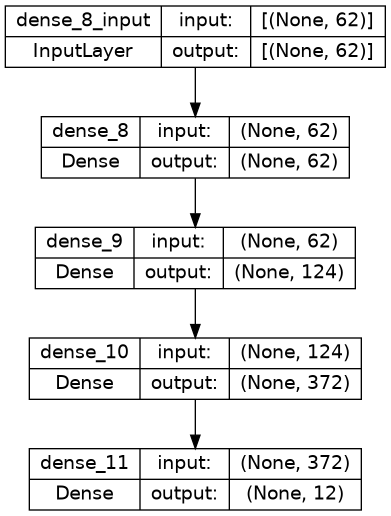

In [114]:
from keras.utils import plot_model

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

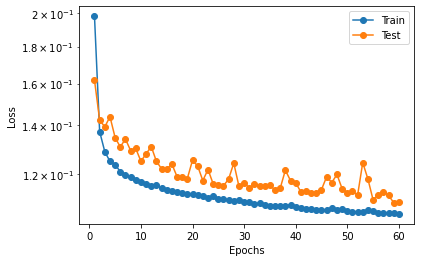

In [115]:
# Extract number of run epochs from the training history
epochs = range(1, len(history.history["loss"])+1)

# Extract loss on training and validation ddataset and plot them together
plt.plot(epochs, history.history["loss"], "o-", label="Train")
plt.plot(epochs, history.history["val_loss"], "o-", label="Test")
#plt.plot(epochs, model.history["mean_squared_error"], "o-", label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend();


In [116]:
prediction = model.predict(X_test)

7133/7133 [==============================] - 4s 576us/step


In [117]:
# prediction = np.array(prediction).reshape(6,232712).transpose()
# prediction.shape

In [118]:
# prediction

In [119]:
#plot distributions also
data_true=pd.DataFrame(y_test)
data_pred=pd.DataFrame(prediction)
data_true.reset_index()
data_pred.reset_index()

print(data_true[:10])
print(data_pred[:10])
#data_pred.rename(columns={"0": "data_true"})#, "1": "Phigentau_1", "2": "Etagentau_1", "3": "Mgentau_1"}, errors="raise")
data_pred.columns = data_true.columns
#print(data_pred[:10])

        gen_nu_px_1  gen_nu_py_1  gen_nu_pz_1  gen_nu_E_1  gen_nu_px_2  \
654713    -1.313443    -0.270276     0.646384    0.280924     0.200461   
164910    -0.063845     0.035647    -0.012833   -0.609205    -0.910761   
402953     0.072889     0.288806    -0.067163   -0.480734    -0.113674   
425165     1.385762    -0.428298     1.854044    1.222646     0.076835   
44402     -0.196519    -0.610376     0.246597   -0.237554     6.553440   
160695    -0.336515    -0.132704    -0.043208   -0.451587     0.126362   
234070     0.514174     0.166410    -0.224775   -0.297141    -0.322724   
213688    -0.041745    -0.019167     0.034932   -0.610668     0.359882   
9131      -0.161788    -0.276782     0.250334   -0.363463     1.182335   
673614     0.216592     0.131691     0.174996   -0.443339    -0.645844   

        gen_nu_py_2  gen_nu_pz_2  gen_nu_E_2  gen_nu_phi_1  gen_nu_eta_1  \
654713     0.297017     0.547951   -0.179747     -1.620349      0.805001   
164910    -1.429376    -0.103739 

In [120]:
data_true = pd.DataFrame(scaler_y.inverse_transform(data_true),columns=data_true.columns)
data_pred = pd.DataFrame(scaler_y.inverse_transform(data_pred),columns=data_pred.columns)

In [121]:
# data_pred.sort_values(by = ['gen_nu_px_1'])
# data_pred[data_pred['gen_nu_px_1']>15]['gen_nu_px_1']
removed_outliers = data_pred['gen_nu_px_1'].between(data_pred['gen_nu_px_1'].quantile(.01), data_pred['gen_nu_px_1'].quantile(.99))
#new_pred = data_pred.copy()
index_namesx1 = data_pred[~removed_outliers].index
x_1 = data_pred.drop(index_namesx1)

removed_outliers = data_pred['gen_nu_px_2'].between(data_pred['gen_nu_px_2'].quantile(.01), data_pred['gen_nu_px_2'].quantile(.99))
index_namesx2 = data_pred[~removed_outliers].index
x_2 = data_pred.drop(index_namesx2)

removed_outliers = data_pred['gen_nu_py_1'].between(data_pred['gen_nu_py_1'].quantile(.01), data_pred['gen_nu_py_1'].quantile(.99))
index_namesy1 = data_pred[~removed_outliers].index
y_1 = data_pred.drop(index_namesy1)

removed_outliers = data_pred['gen_nu_py_2'].between(data_pred['gen_nu_py_2'].quantile(.01), data_pred['gen_nu_py_2'].quantile(.99))
index_namesy2 = data_pred[~removed_outliers].index
y_2 = data_pred.drop(index_namesy2)

removed_outliers = data_pred['gen_nu_pz_1'].between(data_pred['gen_nu_pz_1'].quantile(.01), data_pred['gen_nu_pz_1'].quantile(.99))
index_namesz1 = data_pred[~removed_outliers].index
z_1 = data_pred.drop(index_namesz1)

removed_outliers = data_pred['gen_nu_pz_2'].between(data_pred['gen_nu_pz_2'].quantile(.01), data_pred['gen_nu_pz_2'].quantile(.99))
index_namesz2 = data_pred[~removed_outliers].index
z_2 = data_pred.drop(index_namesz2)

In [122]:
index_name_pi_1 = X_test_inv_o[(X_test_inv_o['dm_1']==0)].index
index_name_rho_1 = X_test_inv_o[(X_test_inv_o['dm_1']==1)].index
index_name_a1_1 = X_test_inv_o[(X_test_inv_o['dm_1']==10)].index

index_name_pi_2 = X_test_inv_o[(X_test_inv_o['dm_2']==0)].index
index_name_rho_2 = X_test_inv_o[(X_test_inv_o['dm_2']==1)].index
index_name_a1_2 = X_test_inv_o[(X_test_inv_o['dm_2']==10)].index

In [123]:
chanel_pi_1_pred = data_pred.iloc[index_name_pi_1]
chanel_rho_1_pred = data_pred.iloc[index_name_rho_1]
chanel_a1_1_pred = data_pred.iloc[index_name_a1_1]

chanel_pi_2_pred = data_pred.iloc[index_name_pi_2]
chanel_rho_2_pred = data_pred.iloc[index_name_rho_2]
chanel_a1_2_pred = data_pred.iloc[index_name_a1_2]

chanel_pi_1_true = data_true.iloc[index_name_pi_1]
chanel_rho_1_true = data_true.iloc[index_name_rho_1]
chanel_a1_1_true = data_true.iloc[index_name_a1_1]

chanel_pi_2_true = data_true.iloc[index_name_pi_2]
chanel_rho_2_true = data_true.iloc[index_name_rho_2]
chanel_a1_2_true = data_true.iloc[index_name_a1_2]

In [124]:
# # plots for pi decays 

# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,18))
# plt.subplot(321)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_1_true['gen_nu_px_1'],chanel_pi_1_pred['gen_nu_px_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{px_1}$ on Gen-level $nu_{px_1}($\pi$ decays)$')
# plt.legend()

# plt.subplot(323)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_1_true['gen_nu_py_1'],chanel_pi_1_pred['gen_nu_py_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{py_1}$ on Gen-level $nu_{py_1}($\pi$ decays)$')
# plt.legend()

# plt.subplot(325)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_1_true['gen_nu_pz_1'],chanel_pi_1_pred['gen_nu_pz_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output')
# plt.title('Regression of Reco-level $nu_{pz_1}$ on Gen-level $nu_{pz_1}$($\pi$ decays)')
# plt.legend()

# plt.subplot(322)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_2_true['gen_nu_px_2'],chanel_pi_2_pred['gen_nu_px_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{px_2}$ on Gen-level $nu_{px_2}$($\pi$ decays)')
# plt.legend()

# plt.subplot(324)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_2_true['gen_nu_py_2'],chanel_pi_2_pred['gen_nu_py_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{py_2}$ on Gen-level $nu_{py_2}$($\pi$ decays)')
# plt.legend()

# plt.subplot(326)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_pi_2_true['gen_nu_pz_2'],chanel_pi_2_pred['gen_nu_pz_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{pz_2}$ on Gen-level $nu_{pz_2}$($\pi$ decays)')
# plt.legend()

In [125]:
# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,18))
# plt.subplot(321)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_1_true['gen_nu_px_1'],chanel_rho_1_pred['gen_nu_px_1'],bins = 100,range = [[-1.5,1.5], [-1.5, 1.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{px_1}$ on Gen-level $nu_{px_1}$')
# plt.legend()

# plt.subplot(323)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_1_true['gen_nu_py_1'],chanel_rho_1_pred['gen_nu_py_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{py_1}$ on Gen-level $nu_{py_1}$')
# plt.legend()

# plt.subplot(325)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_1_true['gen_nu_pz_1'],chanel_rho_1_pred['gen_nu_pz_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output')
# plt.title('Regression of Reco-level $nu_{pz_1}$ on Gen-level $nu_{pz_1}$')
# plt.legend()

# plt.subplot(322)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_2_true['gen_nu_px_2'],chanel_rho_2_pred['gen_nu_px_2'],bins = 100,range = [[-1.5,1.5], [-1.5, 1.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{px_2}$ on Gen-level $nu_{px_2}$($\\rho$ decays)')
# plt.legend()

# plt.subplot(324)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_2_true['gen_nu_py_2'],chanel_rho_2_pred['gen_nu_py_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{py_2}$ on Gen-level $nu_{py_2}$($\\rho$ decays)')
# plt.legend()

# plt.subplot(326)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_rho_2_true['gen_nu_pz_2'],chanel_rho_2_pred['gen_nu_pz_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{pz_2}$ on Gen-level $nu_{pz_2}$($\\rho$ decays)')
# plt.legend()

In [126]:
# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,18))
# plt.subplot(321)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_1_true['gen_nu_px_1'],chanel_a1_1_pred['gen_nu_px_1'],bins = 100,range = [[-1,1], [-1, 1]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{px_1}$ on Gen-level $nu_{px_1}$')
# plt.legend()

# plt.subplot(323)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_1_true['gen_nu_py_1'],chanel_a1_1_pred['gen_nu_py_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{py_1}$ on Gen-level $nu_{py_1}$')
# plt.legend()

# plt.subplot(325)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_1_true['gen_nu_pz_1'],chanel_a1_1_pred['gen_nu_pz_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output')
# plt.title('Regression of Reco-level $nu_{pz_1}$ on Gen-level $nu_{pz_1}$')
# plt.legend()

# plt.subplot(322)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_2_true['gen_nu_px_2'],chanel_a1_2_pred['gen_nu_px_2'],bins = 100,range = [[-1,1], [-1, 1]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{px_2}$ on Gen-level $nu_{px_2}$(a1 decays)')
# plt.legend()

# plt.subplot(324)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_2_true['gen_nu_py_2'],chanel_a1_2_pred['gen_nu_py_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of $nu_{py_2}$ on Gen-level $nu_{py_2}$(a1 decays)')
# plt.legend()

# plt.subplot(326)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(chanel_a1_2_true['gen_nu_pz_2'],chanel_a1_2_pred['gen_nu_pz_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $nu_{pz_2}$ on Gen-level $nu_{pz_2}$(a1 decays)')
# plt.legend()

In [127]:
# plt.hist(y_1['gen_nu_py_1'],bins = 100,range = (-5,5))

In [128]:
#data_true = pd.DataFrame(scaler_y.inverse_transform(data_true),columns=data_true.columns)
#data_pred = pd.DataFrame(scaler_y.inverse_transform(data_pred),columns=data_pred.columns)

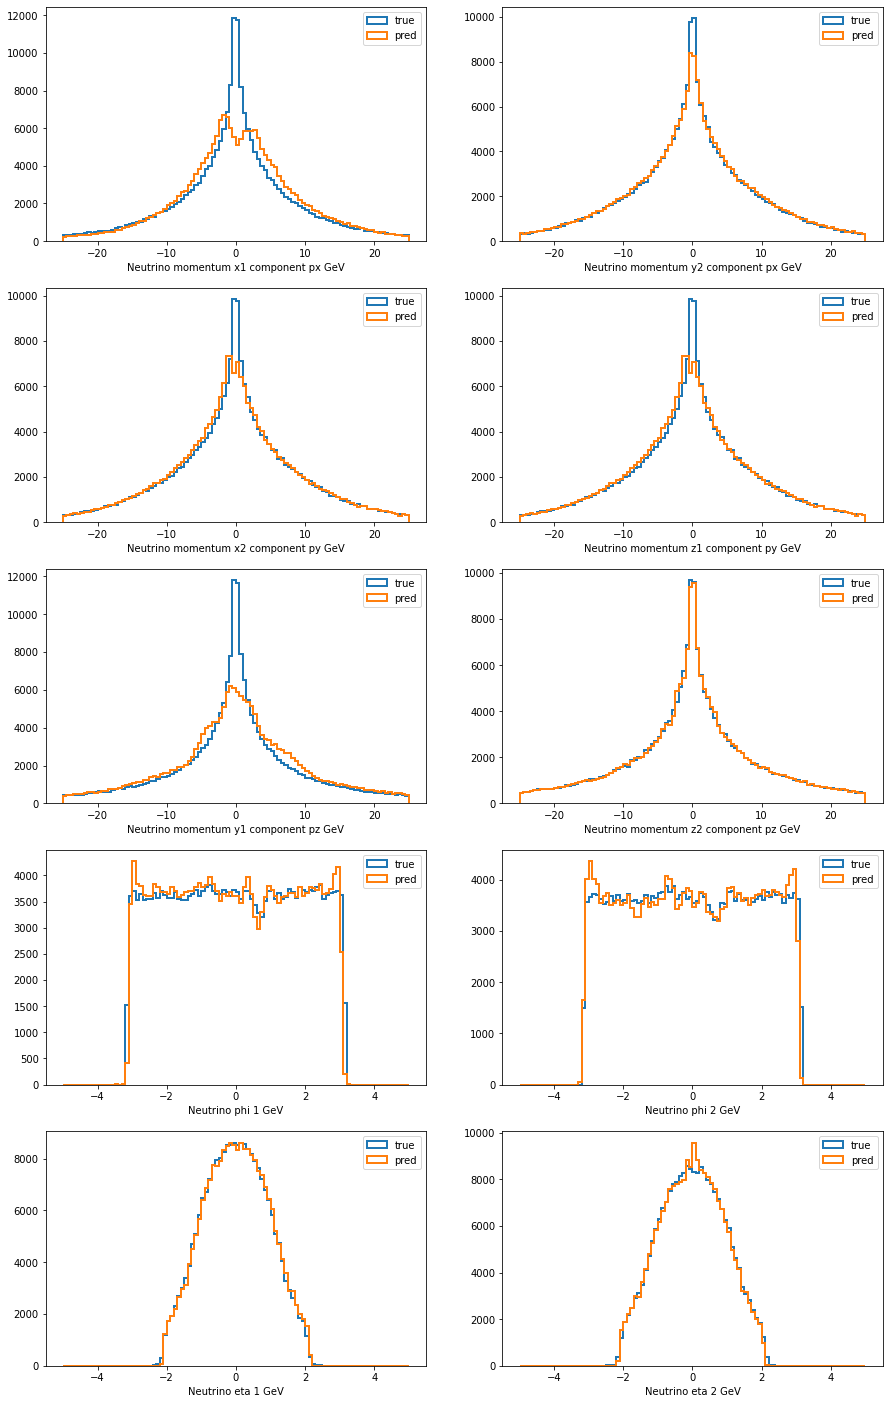

In [129]:
fig = plt.figure(figsize=(15,25))

plt.subplot(521)
plt.hist(data_true['gen_nu_px_1'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_px_1'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum x1 component px GeV')
plt.legend()
plt.subplot(523)
plt.hist(data_true['gen_nu_py_2'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_py_2'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum x2 component py GeV')
plt.legend()
plt.subplot(525)
plt.hist(data_true['gen_nu_pz_1'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_pz_1'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum y1 component pz GeV')
plt.legend()

plt.subplot(522)
plt.hist(data_true['gen_nu_px_2'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_px_2'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum y2 component px GeV')
plt.legend()
plt.subplot(524)
plt.hist(data_true['gen_nu_py_2'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_py_2'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum z1 component py GeV')
plt.legend()
plt.subplot(526)
plt.hist(data_true['gen_nu_pz_2'],bins = 100,range = (-25, 25),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_pz_2'],bins = 100,range = (-25, 25),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino momentum z2 component pz GeV')
plt.legend()


plt.subplot(527)
plt.hist(data_true['gen_nu_phi_1'],bins = 100,range = (-5, 5),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_phi_1'],bins = 100,range = (-5, 5),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino phi 1 GeV')
plt.legend()
plt.subplot(529)
plt.hist(data_true['gen_nu_eta_1'],bins = 100,range = (-5, 5),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_eta_1'],bins = 100,range = (-5, 5),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino eta 1 GeV')
plt.legend()

plt.subplot(528)
plt.hist(data_true['gen_nu_phi_2'],bins = 100,range = (-5, 5),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_phi_2'],bins = 100,range = (-5, 5),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino phi 2 GeV')
plt.legend()
plt.subplot(5,2,10)
plt.hist(data_true['gen_nu_eta_2'],bins = 100,range = (-5, 5),label='true',histtype = u'step',lw = 2)
plt.hist(data_pred['gen_nu_eta_2'],bins = 100,range = (-5, 5),label='pred',histtype = u'step',lw = 2)
plt.xlabel('Neutrino eta 2 GeV')
plt.legend()

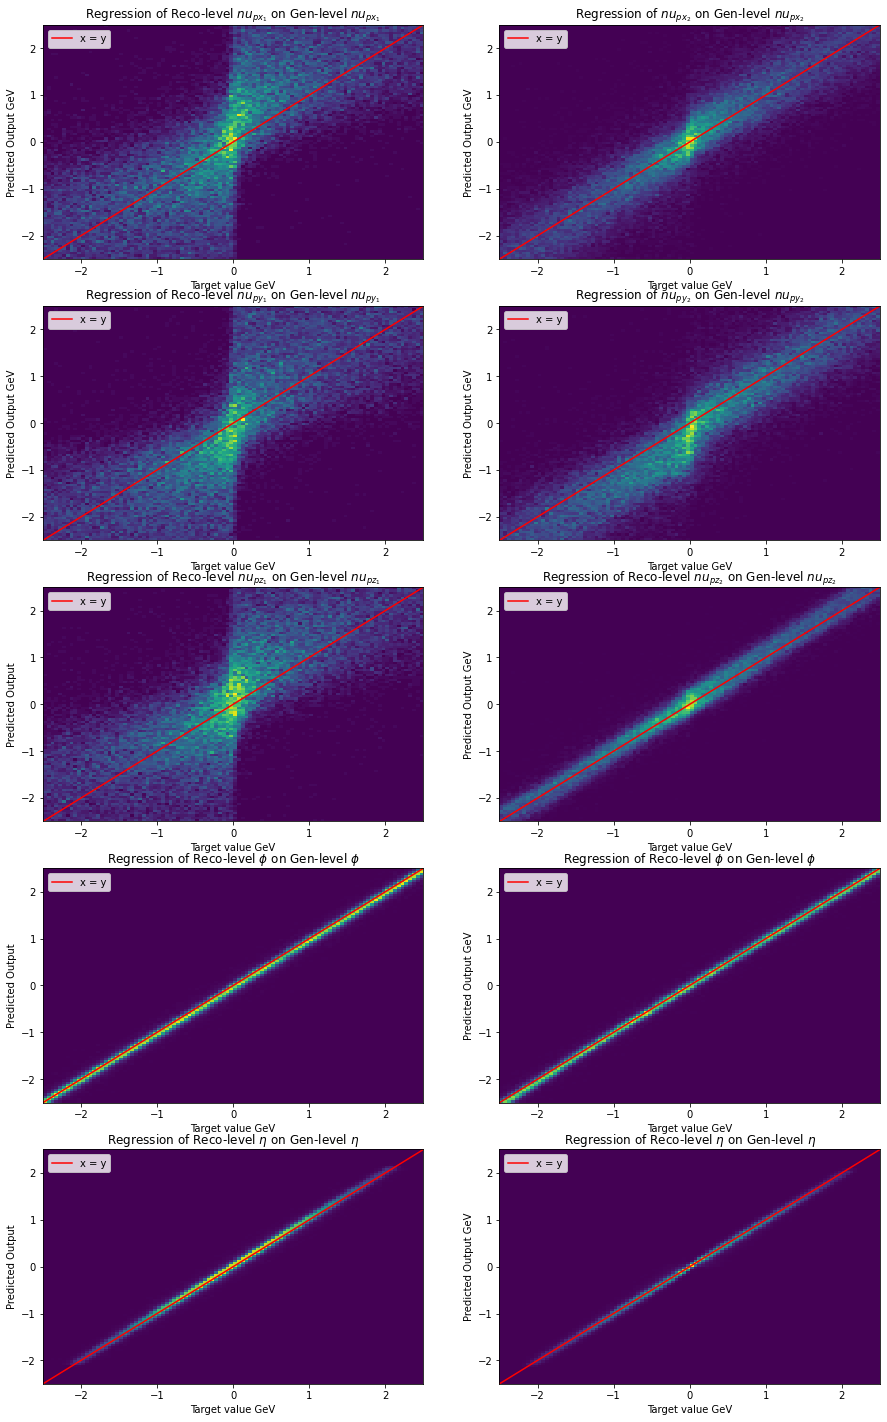

In [130]:
x = np.linspace(-500,640,100)
y = x

fig = plt.figure(figsize=(15,25))
plt.subplot(521)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_px_1'],data_pred['gen_nu_px_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of Reco-level $nu_{px_1}$ on Gen-level $nu_{px_1}$')
plt.legend()

plt.subplot(523)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_py_1'],data_pred['gen_nu_py_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of Reco-level $nu_{py_1}$ on Gen-level $nu_{py_1}$')
plt.legend()

plt.subplot(525)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_pz_1'],data_pred['gen_nu_pz_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output')
plt.title('Regression of Reco-level $nu_{pz_1}$ on Gen-level $nu_{pz_1}$')
plt.legend()

plt.subplot(527)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_phi_1'],data_pred['gen_nu_phi_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output')
plt.title('Regression of Reco-level $\phi$ on Gen-level $\phi$')
plt.legend()

plt.subplot(529)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_eta_1'],data_pred['gen_nu_eta_1'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output')
plt.title('Regression of Reco-level $\eta$ on Gen-level $\eta$')
plt.legend()

plt.subplot(522)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_px_2'],data_pred['gen_nu_px_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of $nu_{px_2}$ on Gen-level $nu_{px_2}$')
plt.legend()

plt.subplot(524)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_py_2'],data_pred['gen_nu_py_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of $nu_{py_2}$ on Gen-level $nu_{py_2}$')
plt.legend()

plt.subplot(526)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_pz_2'],data_pred['gen_nu_pz_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of Reco-level $nu_{pz_2}$ on Gen-level $nu_{pz_2}$')
plt.legend()

plt.subplot(528)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_phi_2'],data_pred['gen_nu_phi_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of Reco-level $\phi$ on Gen-level $\phi$')
plt.legend()

plt.subplot(5,2,10)
#plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
plt.hist2d(data_true['gen_nu_eta_2'],data_pred['gen_nu_eta_2'],bins = 100,range = [[-2.5,2.5], [-2.5, 2.5]])
plt.plot(x,y,'r-',label = 'x = y')
plt.xlabel('Target value GeV')
plt.ylabel('Predicted Output GeV')
plt.title('Regression of Reco-level $\eta$ on Gen-level $\eta$')
plt.legend()

In [131]:
X_test_o = pd.DataFrame(scaler_x.inverse_transform(X_test_o),columns=X_test_o.columns)

In [132]:
from sklearn.metrics import mean_squared_error

rms_x1_ml = np.sqrt(mean_squared_error(data_true['gen_nu_px_1'].reset_index()['gen_nu_px_1'], data_pred['gen_nu_px_1']))
rms_x1_sv = np.sqrt(mean_squared_error(X_test_o['reco_x_1']+data_true['gen_nu_px_1'], X_test_o['svfit_px_1']))

rms_x2_ml = np.sqrt(mean_squared_error(data_true['gen_nu_px_2'].reset_index()['gen_nu_px_2'], data_pred['gen_nu_px_2']))
rms_x2_sv = np.sqrt(mean_squared_error(X_test_o['reco_x_2']+data_true['gen_nu_px_2'], X_test_o['svfit_px_2']))

rms_y1_ml = np.sqrt(mean_squared_error(data_true['gen_nu_py_1'].reset_index()['gen_nu_py_1'], data_pred['gen_nu_py_1']))
rms_y1_sv = np.sqrt(mean_squared_error(X_test_o['reco_y_1']+data_true['gen_nu_py_1'], X_test_o['svfit_py_1']))

rms_y2_ml = np.sqrt(mean_squared_error(data_true['gen_nu_py_2'].reset_index()['gen_nu_py_2'], data_pred['gen_nu_py_2']))
rms_y2_sv = np.sqrt(mean_squared_error(X_test_o['reco_y_2']+data_true['gen_nu_py_2'], X_test_o['svfit_py_2']))

rms_z1_ml = np.sqrt(mean_squared_error(data_true['gen_nu_pz_1'].reset_index()['gen_nu_pz_1'], data_pred['gen_nu_pz_1']))
rms_z1_sv = np.sqrt(mean_squared_error(X_test_o['reco_z_1']+data_true['gen_nu_pz_1'], X_test_o['svfit_pz_1']))

rms_z2_ml = np.sqrt(mean_squared_error(data_true['gen_nu_pz_2'].reset_index()['gen_nu_pz_2'], data_pred['gen_nu_pz_2']))
rms_z2_sv = np.sqrt(mean_squared_error(X_test_o['reco_z_2']+data_true['gen_nu_pz_2'], X_test_o['svfit_pz_2']))

rms_eta1_ml = np.sqrt(mean_squared_error(data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1'], data_pred['gen_nu_eta_1']))
rms_eta1_sv = np.sqrt(mean_squared_error(X_test_o['reco_eta_1']+data_true['gen_nu_eta_1'], X_test_o['svfit_eta_1']))

rms_eta2_ml = np.sqrt(mean_squared_error(data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2'], data_pred['gen_nu_eta_2']))
rms_eta2_sv = np.sqrt(mean_squared_error(X_test_o['reco_eta_2']+data_true['gen_nu_eta_2'], X_test_o['svfit_eta_2']))

rms_phi1_ml = np.sqrt(mean_squared_error(data_true['gen_nu_phi_1'].reset_index()['gen_nu_phi_1'], data_pred['gen_nu_phi_1']))
rms_phi1_sv = np.sqrt(mean_squared_error(X_test_o['reco_phi_1']+data_true['gen_nu_phi_1'], X_test_o['svfit_phi_1']))

rms_phi2_ml = np.sqrt(mean_squared_error(data_true['gen_nu_phi_2'].reset_index()['gen_nu_phi_2'], data_pred['gen_nu_phi_2']))
rms_phi2_sv = np.sqrt(mean_squared_error(X_test_o['reco_phi_2']+data_true['gen_nu_phi_2'], X_test_o['svfit_phi_2']))

In [133]:
c1 = X_test.reset_index()['pt_1']
c2 = X_test.reset_index()['pt_2']
data_true['pt_1'],data_true['pt_2']=c1,c2
data_pred['pt_1'],data_pred['pt_2']=c1,c2

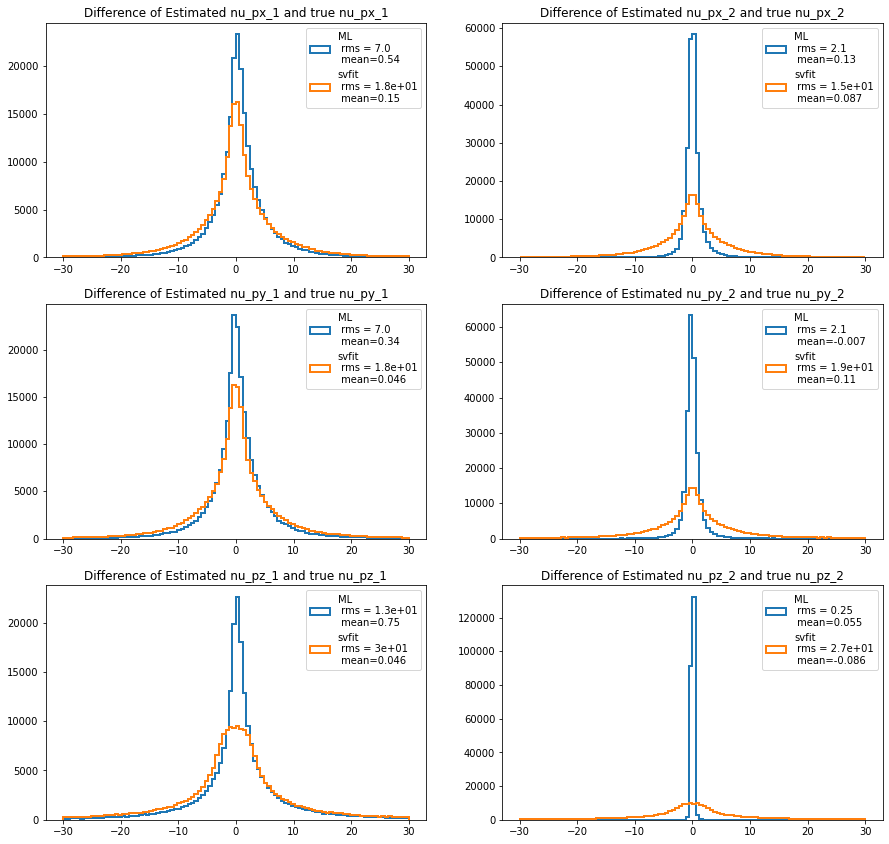

In [134]:
fig = plt.figure(figsize=(15,25))
ran_1 = (-30,30)
ran_2 = (-10,10)

plt.subplot(521)
x_1_ml = data_pred['gen_nu_px_1']-data_true['gen_nu_px_1'].reset_index()['gen_nu_px_1']
x_1_sv = X_test_o['svfit_px_1']-X_test_o['reco_x_1']-data_true['gen_nu_px_1']
plt.hist(x_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_ml,np.mean(x_1_ml)))
plt.hist(x_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_sv,np.mean(x_1_sv)))
plt.title('Difference of Estimated nu_px_1 and true nu_px_1')
plt.legend()

plt.subplot(522)
x_2_ml = data_pred['gen_nu_px_2']-data_true['gen_nu_px_2'].reset_index()['gen_nu_px_2']
x_2_sv = X_test_o['svfit_px_2']-X_test_o['reco_x_2']-data_true['gen_nu_px_2']
plt.hist(x_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_x2_ml,np.mean(x_2_ml)))
plt.hist(x_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_x2_sv,np.mean(x_2_sv)))
plt.title('Difference of Estimated nu_px_2 and true nu_px_2')
plt.legend()

plt.subplot(523)
y_1_ml = data_pred['gen_nu_py_1']-data_true['gen_nu_py_1'].reset_index()['gen_nu_py_1']
y_1_sv = X_test_o['svfit_py_1']-X_test_o['reco_y_1']-data_true['gen_nu_py_1']
plt.hist(y_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_y1_ml,np.mean(y_1_ml)))
plt.hist(y_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_y1_sv,np.mean(y_1_sv)))
plt.title('Difference of Estimated nu_py_1 and true nu_py_1')
plt.legend()

plt.subplot(524)
y_2_ml = data_pred['gen_nu_py_2']-data_true['gen_nu_py_2'].reset_index()['gen_nu_py_2']
y_2_sv = X_test_o['svfit_py_2']-X_test_o['reco_y_2']-data_true['gen_nu_py_2']
plt.hist(y_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_y2_ml,np.mean(y_2_ml)))
plt.hist(y_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_y2_sv,np.mean(y_2_sv)))
plt.title('Difference of Estimated nu_py_2 and true nu_py_2')
plt.legend()

plt.subplot(525)
z_1_ml = data_pred['gen_nu_pz_1']-data_true['gen_nu_pz_1'].reset_index()['gen_nu_pz_1']
z_1_sv = X_test_o['svfit_pz_1']-X_test_o['reco_z_1']-data_true['gen_nu_pz_1']
plt.hist(z_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_z1_ml,np.mean(z_1_ml)))
plt.hist(z_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_z1_sv,np.mean(z_1_sv)))
plt.title('Difference of Estimated nu_pz_1 and true nu_pz_1')
plt.legend()

plt.subplot(526)
z_2_ml = data_pred['gen_nu_pz_2']-data_true['gen_nu_pz_2'].reset_index()['gen_nu_pz_2']
z_2_sv = X_test_o['svfit_pz_2']-X_test_o['reco_z_2']-data_true['gen_nu_pz_2']
plt.hist(z_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_z2_ml,np.mean(z_2_ml)))
plt.hist(z_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_z2_sv,np.mean(z_2_sv)))
plt.title('Difference of Estimated nu_pz_2 and true nu_pz_2')
plt.legend()

In [135]:
# fig = plt.figure(figsize=(16,25))

# plt.subplot(321)
# x_1_ml = data_pred[(data_pred['pt_1']<45)]['gen_nu_px_1']-data_true[(data_true['pt_1']<50)]['gen_nu_px_1'].reset_index()['gen_nu_px_1']
# x_1_sv = X_test_o[(X_test_o['pt_1']<45)]['svfit_px_1']-X_test_o[(X_test_o['pt_1']<50)]['reco_x_1']-data_true[(data_true['pt_1']<45)]['gen_nu_px_1']
# plt.hist(x_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_ml,np.mean(x_1_ml)))
# plt.hist(x_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_sv,np.mean(x_1_sv)))
# plt.title('Difference of Estimated nu_px_1 and true nu_px_1')
# plt.legend()

# plt.subplot(322)
# x_2_ml = data_pred[(data_pred['pt_2']<45)]['gen_nu_px_2']-data_true[(data_true['pt_2']<50)]['gen_nu_px_2'].reset_index()['gen_nu_px_2']
# x_2_sv = X_test_o[(X_test_o['pt_2']<45)]['svfit_px_2']-X_test_o[(X_test_o['pt_2']<50)]['reco_x_2']-data_true[(data_true['pt_2']<45)]['gen_nu_px_2']
# plt.hist(x_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_ml,np.mean(x_2_ml)))
# plt.hist(x_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_sv,np.mean(x_2_sv)))
# plt.title('Difference of Estimated nu_px_2 and true nu_px_2')
# plt.legend()

# plt.subplot(321)
# x_1_ml = data_pred[(data_pred['pt_1']<45)]['gen_nu_px_1']-data_true[(data_true['pt_1']<50)]['gen_nu_px_1'].reset_index()['gen_nu_px_1']
# x_1_sv = X_test_o[(X_test_o['pt_1']<45)]['svfit_px_1']-X_test_o[(X_test_o['pt_1']<50)]['reco_x_1']-data_true[(data_true['pt_1']<45)]['gen_nu_px_1']
# plt.hist(x_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_ml,np.mean(x_1_ml)))
# plt.hist(x_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_sv,np.mean(x_1_sv)))
# plt.title('Difference of Estimated nu_px_1 and true nu_px_1')
# plt.legend()

# plt.subplot(322)
# x_2_ml = data_pred[(data_pred['pt_2']<45)]['gen_nu_px_2']-data_true[(data_true['pt_2']<50)]['gen_nu_px_2'].reset_index()['gen_nu_px_2']
# x_2_sv = X_test_o[(X_test_o['pt_2']<45)]['svfit_px_2']-X_test_o[(X_test_o['pt_2']<50)]['reco_x_2']-data_true[(data_true['pt_2']<45)]['gen_nu_px_2']
# plt.hist(x_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_ml,np.mean(x_2_ml)))
# plt.hist(x_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_sv,np.mean(x_2_sv)))
# plt.title('Difference of Estimated nu_px_2 and true nu_px_2')
# plt.legend()

# plt.subplot(321)
# x_1_ml = data_pred[(data_pred['pt_1']<45)]['gen_nu_px_1']-data_true[(data_true['pt_1']<50)]['gen_nu_px_1'].reset_index()['gen_nu_px_1']
# x_1_sv = X_test_o[(X_test_o['pt_1']<45)]['svfit_px_1']-X_test_o[(X_test_o['pt_1']<50)]['reco_x_1']-data_true[(data_true['pt_1']<45)]['gen_nu_px_1']
# plt.hist(x_1_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_ml,np.mean(x_1_ml)))
# plt.hist(x_1_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x1_sv,np.mean(x_1_sv)))
# plt.title('Difference of Estimated nu_px_1 and true nu_px_1')
# plt.legend()

# plt.subplot(322)
# x_2_ml = data_pred[(data_pred['pt_2']<45)]['gen_nu_px_2']-data_true[(data_true['pt_2']<50)]['gen_nu_px_2'].reset_index()['gen_nu_px_2']
# x_2_sv = X_test_o[(X_test_o['pt_2']<45)]['svfit_px_2']-X_test_o[(X_test_o['pt_2']<50)]['reco_x_2']-data_true[(data_true['pt_2']<45)]['gen_nu_px_2']
# plt.hist(x_2_ml,range=ran_1,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_ml,np.mean(x_2_ml)))
# plt.hist(x_2_sv,range=ran_1,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:.2}\n mean={1:0.2}'.format(rms_x2_sv,np.mean(x_2_sv)))
# plt.title('Difference of Estimated nu_px_2 and true nu_px_2')
# plt.legend()

In [136]:
# data_pred = data_pred[(data_pred['gen_nu_py_1']<(np.pi/2))&(data_pred['gen_nu_py_1']>(-np.pi/2))&(data_pred['gen_nu_py_2']<(np.pi/2))&(data_pred['gen_nu_py_2']>(-np.pi/2))]
# data_true = data_pred[(data_true['gen_nu_py_1']<(np.pi/2))&(data_true['gen_nu_py_1']>(-np.pi/2))&(data_pred['gen_nu_py_2']<(np.pi/2))&(data_pred['gen_nu_py_2']>(-np.pi/2))]

In [137]:
phi_sv_x_1 = X_test_o['svfit_px_1']-X_test_o['reco_x_1']
phi_sv_y_1 = X_test_o['svfit_py_1']-X_test_o['reco_y_1']
phi_sv_z_1 = X_test_o['svfit_pz_1']-X_test_o['reco_z_1']
phi_sv_E_1 = X_test_o['svfit_E_1']-X_test_o['reco_E_1']
delphi_1 = vector.obj(px=data_pred['gen_nu_px_1'], py=data_pred['gen_nu_py_1'], pz=data_pred['gen_nu_pz_1'], E=data_pred['gen_nu_E_1']).deltaphi(vector.obj(px=data_true['gen_nu_px_1'], py=data_true['gen_nu_py_1'], pz=data_true['gen_nu_pz_1'], E=data_true['gen_nu_E_1']))
delphi_sv_1 = vector.obj(px=phi_sv_x_1, py=phi_sv_y_1, pz=phi_sv_z_1, E=phi_sv_E_1).deltaphi(vector.obj(px=data_true['gen_nu_px_1'], py=data_true['gen_nu_py_1'], pz=data_true['gen_nu_pz_1'], E=data_true['gen_nu_E_1']))

phi_sv_x_2 = X_test_o['svfit_px_2']-X_test_o['reco_x_2']
phi_sv_y_2 = X_test_o['svfit_py_2']-X_test_o['reco_y_2']
phi_sv_z_2 = X_test_o['svfit_pz_2']-X_test_o['reco_z_2']
phi_sv_E_2 = X_test_o['svfit_E_2']-X_test_o['reco_E_2']
delphi_2 = vector.obj(px=data_pred['gen_nu_px_2'], py=data_pred['gen_nu_py_2'], pz=data_pred['gen_nu_pz_2'], E=data_pred['gen_nu_E_2']).deltaphi(vector.obj(px=data_true['gen_nu_px_2'], py=data_true['gen_nu_py_2'], pz=data_true['gen_nu_pz_2'], E=data_true['gen_nu_E_2']))
delphi_sv_2 = vector.obj(px=phi_sv_x_2, py=phi_sv_y_2, pz=phi_sv_z_2, E=phi_sv_E_2).deltaphi(vector.obj(px=data_true['gen_nu_px_2'], py=data_true['gen_nu_py_2'], pz=data_true['gen_nu_pz_2'], E=data_true['gen_nu_E_2']))

In [162]:
eta_1 = np.arcsinh(data_pred['gen_nu_pz_1']/np.sqrt(data_pred['gen_nu_py_1']**2+data_pred['gen_nu_px_1']**2))
eta_1_sv = np.arcsinh((X_test_o['svfit_pz_1']-X_test_o['reco_z_1'])/np.sqrt((X_test_o['svfit_py_1']-X_test_o['reco_y_1'])**2+(X_test_o['svfit_px_1']-X_test_o['reco_x_1'])**2))
eta_2 = np.arcsinh(data_pred['gen_nu_pz_2']/np.sqrt(data_pred['gen_nu_py_2']**2+data_pred['gen_nu_px_2']**2))
eta_2_sv = np.arcsinh((X_test_o['svfit_pz_2']-X_test_o['reco_z_2'])/np.sqrt((X_test_o['svfit_py_2']-X_test_o['reco_y_2'])**2+(X_test_o['svfit_px_2']-X_test_o['reco_x_2'])**2))

In [165]:
rms_eta1_co = np.sqrt(mean_squared_error(eta_1,data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1']))
rms_eta1_sv = np.sqrt(mean_squared_error(eta_1_sv,data_true['gen_nu_eta_1']))

rms_eta2_co = np.sqrt(mean_squared_error(eta_2,data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2']))
rms_eta2_sv = np.sqrt(mean_squared_error(eta_2_sv,data_true['gen_nu_eta_2']))


MSE_1_co = np.square(delphi_1).mean() 
rms_phi1_co = np.sqrt(MSE_1_co)
MSE_1_sv = np.square(delphi_sv_1).mean()
rms_phi1_sv = np.sqrt(MSE_1_sv)

MSE_2_co = np.square(delphi_2).mean() 
rms_phi2_co = np.sqrt(MSE_2_co)
MSE_2_sv = np.square(delphi_sv_2).mean()
rms_phi2_sv = np.sqrt(MSE_2_sv)

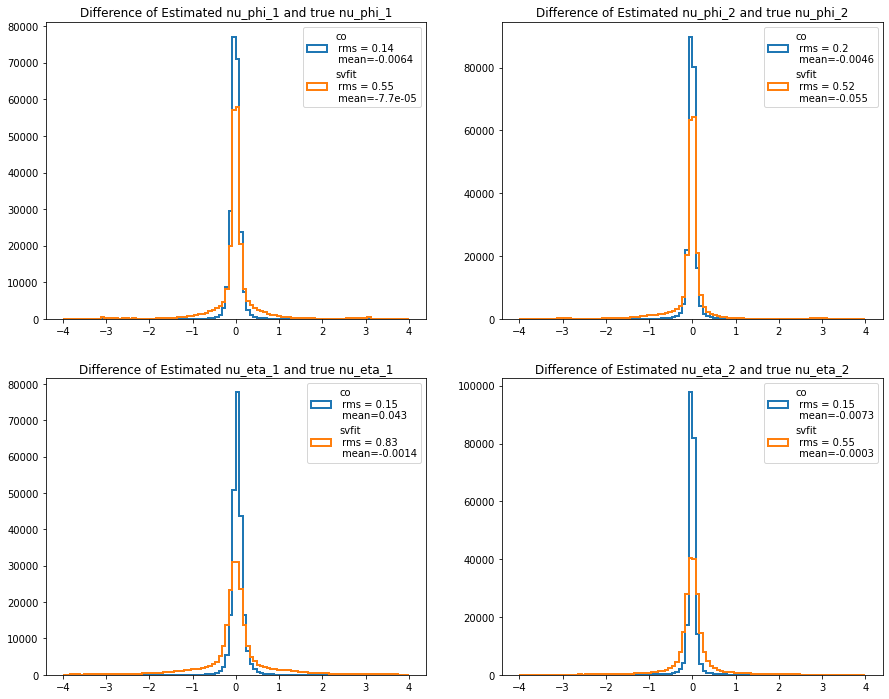

In [166]:
fig = plt.figure(figsize=(15,12))
ran_2 = (-4,4)
plt.subplot(221)
phi_1_ml = data_pred['gen_nu_phi_1']-data_true['gen_nu_phi_1'].reset_index()['gen_nu_phi_1']
phi_1_co = delphi_1
#phi_1_sv_nu = phi_1_sv-data_true['gen_nu_phi_1']
#plt.hist(phi_1_ml,range=ran_2,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_ml,np.mean(phi_1_ml)))
plt.hist(phi_1_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_co,np.mean(delphi_1)))
plt.hist(delphi_sv_1,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_sv,np.mean(delphi_sv_1)))
plt.title('Difference of Estimated nu_phi_1 and true nu_phi_1')
plt.legend()
plt.subplot(222)
phi_2_ml = data_pred['gen_nu_phi_2']-data_true['gen_nu_phi_2'].reset_index()['gen_nu_phi_2']
#phi_2_co = phi_2-data_true['gen_nu_phi_2'].reset_index()['gen_nu_phi_2']
phi_2_co = delphi_2
#phi_2_sv_nu = phi_2_sv-data_true['gen_nu_phi_2']
#plt.hist(phi_2_ml,range=ran_2,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_ml,np.mean(phi_2_ml)))
plt.hist(phi_2_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_co,np.mean(delphi_2)))
plt.hist(delphi_sv_2,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_sv,np.mean(delphi_sv_2)))
plt.title('Difference of Estimated nu_phi_2 and true nu_phi_2')
plt.legend()

plt.subplot(223)
eta_1_ml = data_pred['gen_nu_eta_1']-data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1']
eta_1_co = eta_1-data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1']
eta_1_sv_nu = eta_1_sv-data_true['gen_nu_eta_1']
#plt.hist(phi_1_ml,range=ran_2,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_ml,np.mean(phi_1_ml)))
plt.hist(eta_1_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta1_co,np.mean(eta_1_co)))
plt.hist(eta_1_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta1_sv,np.mean(eta_1_sv_nu)))
plt.title('Difference of Estimated nu_eta_1 and true nu_eta_1')
plt.legend()
plt.subplot(224)
eta_2_ml = data_pred['gen_nu_eta_2']-data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2']
eta_2_co = eta_2-data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2']
eta_2_sv_nu = eta_2_sv-data_true['gen_nu_eta_2']
#plt.hist(phi_2_ml,range=ran_2,histtype=u'step',lw=2,bins=100,label='ML \n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_ml,np.mean(phi_2_ml)))
plt.hist(eta_2_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta2_co,np.mean(eta_2_co)))
plt.hist(eta_2_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta2_sv,np.mean(eta_2_sv_nu)))
plt.title('Difference of Estimated nu_eta_2 and true nu_eta_2')
plt.legend()

In [190]:
rms_eta1_co = np.sqrt(mean_squared_error(eta_1.iloc[index_name_rho_1],data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1'].iloc[index_name_rho_1]))
rms_eta1_sv = np.sqrt(mean_squared_error(eta_1_sv.iloc[index_name_rho_1],data_true['gen_nu_eta_1'].iloc[index_name_rho_1]))

rms_eta2_co = np.sqrt(mean_squared_error(eta_2.iloc[index_name_rho_1],data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2'].iloc[index_name_rho_1]))
rms_eta2_sv = np.sqrt(mean_squared_error(eta_2_sv.iloc[index_name_rho_1],data_true['gen_nu_eta_2'].iloc[index_name_rho_1]))


MSE_1_co = np.square(delphi_1.iloc[index_name_rho_1]).mean() 
rms_phi1_co = np.sqrt(MSE_1_co)
MSE_1_sv = np.square(delphi_sv_1.iloc[index_name_rho_1]).mean()
rms_phi1_sv = np.sqrt(MSE_1_sv)

MSE_2_co = np.square(delphi_2.iloc[index_name_rho_1]).mean() 
rms_phi2_co = np.sqrt(MSE_2_co)
MSE_2_sv = np.square(delphi_sv_2.iloc[index_name_rho_1]).mean()
rms_phi2_sv = np.sqrt(MSE_2_sv)

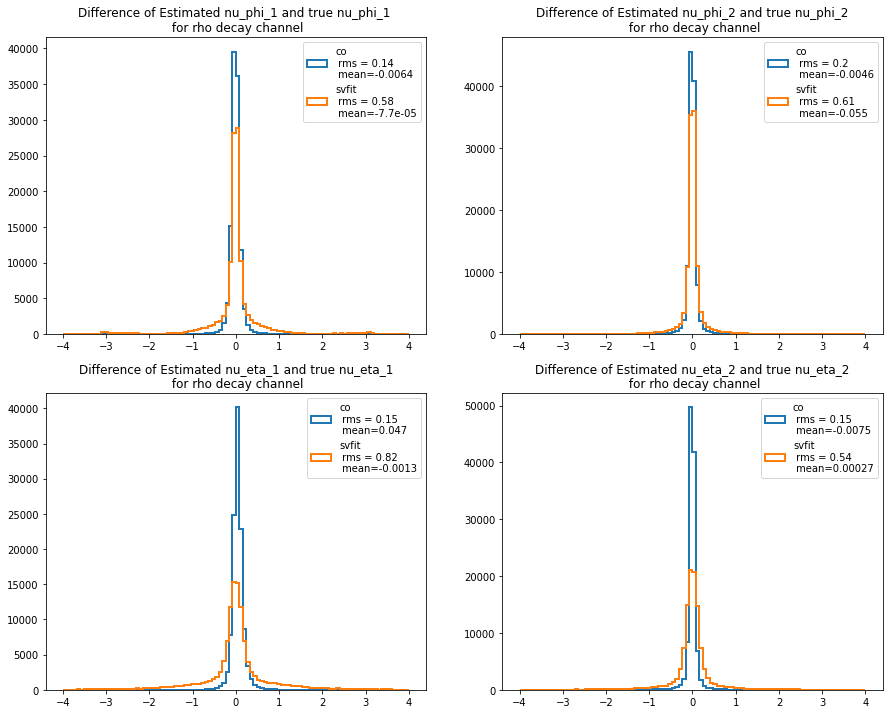

In [191]:
# a1a1 decays
fig = plt.figure(figsize=(15,12))
ran_2 = (-4,4)
plt.subplot(221)
phi_1_co = delphi_1.iloc[index_name_rho_1]
phi_1_sv_nu = delphi_sv_1.iloc[index_name_rho_1]
plt.hist(phi_1_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_co,np.mean(delphi_1)))
plt.hist(phi_1_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi1_sv,np.mean(delphi_sv_1)))
plt.title('Difference of Estimated nu_phi_1 and true nu_phi_1 \n for rho decay channel')
plt.legend()

plt.subplot(222)
phi_2_co = delphi_2.iloc[index_name_rho_2]
phi_2_sv_nu = delphi_sv_2.iloc[index_name_rho_2]
plt.hist(phi_2_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_co,np.mean(delphi_2)))
plt.hist(phi_2_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_phi2_sv,np.mean(delphi_sv_2)))
plt.title('Difference of Estimated nu_phi_2 and true nu_phi_2\n for rho decay channel')
plt.legend()

plt.subplot(223)
eta_1_co = eta_1.iloc[index_name_rho_1]-data_true['gen_nu_eta_1'].reset_index()['gen_nu_eta_1'].iloc[index_name_rho_1]
eta_1_sv_nu = eta_1_sv.iloc[index_name_rho_1]-data_true['gen_nu_eta_1'].iloc[index_name_rho_1]
plt.hist(eta_1_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta1_co,np.mean(eta_1_co)))
plt.hist(eta_1_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta1_sv,np.mean(eta_1_sv_nu)))
plt.title('Difference of Estimated nu_eta_1 and true nu_eta_1\n for rho decay channel')
plt.legend()

plt.subplot(224)
eta_2_co = eta_2.iloc[index_name_rho_2]-data_true['gen_nu_eta_2'].reset_index()['gen_nu_eta_2'].iloc[index_name_rho_2]
eta_2_sv_nu = eta_2_sv.iloc[index_name_rho_2]-data_true['gen_nu_eta_2'].iloc[index_name_rho_2]
plt.hist(eta_2_co,range=ran_2,histtype=u'step',lw=2,bins=100,label='co\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta2_co,np.mean(eta_2_co)))
plt.hist(eta_2_sv_nu,range=ran_2,histtype=u'step',lw=2,bins=100,label='svfit\n rms = {0:0.2}\n mean={1:0.2}'.format(rms_eta2_sv,np.mean(eta_2_sv_nu)))
plt.title('Difference of Estimated nu_eta_2 and true nu_eta_2\n for rho decay channel')
plt.legend()


In [ ]:
# nbins=100

# fig = plt.figure(figsize=(15,12))
# plt.subplot(221)

# plt.hist(data_true['gen_p'],bins=nbins, histtype=u'step', lw=2, label='true',range=(0,500))
# plt.hist(data_pred['gen_p'],bins=nbins, histtype=u'step', lw=2, label='predicted',range=(0,500))
# #plt.hist(X_test['reco_vis_p_1'],bins=nbins, histtype=u'step', lw=2, label='true(reco_vis+gen_nu)',range=(0,300))
# plt.xlabel('Higgs momentum GeV')
# plt.title('Distribution of Higgs Momentum at Generated Level')
# plt.legend()

# plt.subplot(222)
# plt.hist(data_true['gen_px'],bins=nbins, histtype=u'step', lw=2, label='true',range=(-100,100))
# plt.hist(data_pred['gen_px'],bins=nbins, histtype=u'step', lw=2, label='predicted',range=(-100,100))
# #plt.hist(X_test['reco_vis_p_1'],bins=nbins, histtype=u'step', lw=2, label='true(reco_vis+gen_nu)',range=(0,300))
# plt.xlabel('Higgs x momentum GeV')
# plt.title('Distribution of Higgs x Momentum at Generated Level')
# plt.legend()

# plt.subplot(223)
# plt.hist(data_true['gen_py'],bins=nbins, histtype=u'step', lw=2, label='true',range=(-100,100))
# plt.hist(data_pred['gen_py'],bins=nbins, histtype=u'step', lw=2, label='predicted',range=(-100,100))
# #plt.hist(X_test['reco_vis_p_1'],bins=nbins, histtype=u'step', lw=2, label='true(reco_vis+gen_nu)',range=(0,300))
# plt.xlabel('Higgs y momentum GeV')
# plt.title('Distribution of Higgs y Momentum at Generated Level')
# plt.legend()

# plt.subplot(224)
# plt.hist(data_true['gen_pz'],bins=nbins, histtype=u'step', lw=2, label='true',range=(-500,500))
# plt.hist(data_pred['gen_pz'],bins=nbins, histtype=u'step', lw=2, label='predicted',range=(-500,500))
# #plt.hist(X_test['reco_vis_p_1'],bins=nbins, histtype=u'step', lw=2, label='true(reco_vis+gen_nu)',range=(0,300))
# plt.xlabel('Higgs z momentum GeV')
# plt.title('Distribution of Higgs z Momentum at Generated Level')
# plt.legend()

In [ ]:
# Tau_p_1 = X_test['reco_p']

# Tau_gen_p_1 = y_test['gen_p']

# #y_test_new = pd.DataFrame(scaler_y.inverse_transform(data_pred),columns=y_test.columns)
# y_test_new = pd.DataFrame(data_pred,columns=y_test.columns)
# Tau_p_1_r = Tau_p_1/Tau_gen_p_1
# #Tau_vis_p_1 = X_test["gen_vis_p_1"]/Tau_gen_p_1
# Tau_p_1_new = y_test_new["gen_p"]/Tau_gen_p_1

# plt.hist(Tau_p_1_r,bins=nbins, histtype=u'step', lw=2, label='$\\frac{P_{reco}}{P_{gen}}$', density=True,range=(0.01,5))
# #plt.hist(Tau_vis_p_1,bins=nbins, histtype=u'step', lw=2, label='$\\frac{P_{vis}}{P_{gen}}(generated)$', density=True,range=(0.01,3))
# plt.hist(Tau_p_1_new,bins=nbins, histtype=u'step', lw=2, label='$\\frac{P_{reco}}{P_{gen}}$(predicted)', density=True,range=(0.01,5))
# plt.xlabel('ratio of momentums')
# plt.title('Distribution of real and predicted $\\frac{P_{reco}}{P_{gen}}$')
# plt.legend()

# # print(Tau_p_1_r.mean(), Tau_p_1_r.std())
# # print(Tau_p_1_new.mean(), Tau_p_1_new.std())
# # print(X_test["reco_p"][:10])    

In [ ]:
# plt.hist(X_test["reco_vis_p_1"]/X_test['gen_vis_p_1'],bins = 100,range=(0,10))
# plt.xlabel('$\\frac{P_{reco_vis}}{P_{gen_vis}}$')
# plt.title('Distribution of real and predicted $\\frac{P_{recovis}}{P_{genvis}}$')

In [ ]:
# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,12))
# plt.subplot(221)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(data_true['gen_p'],data_pred['gen_p'],bins = 100,range = [[-500,500], [-500, 500]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_H$ on Gen-level $P_H$')
# plt.legend()

# plt.subplot(222)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(data_true['gen_px'],data_pred['gen_px'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_{Hx}$ on Gen-level $P_{Hx}$')
# plt.legend()

# plt.subplot(223)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(data_true['gen_py'],data_pred['gen_py'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_{Hy}$ on Gen-level $P_{Hy}$')
# plt.legend()

# plt.subplot(224)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(data_true['gen_pz'],data_pred['gen_pz'],bins = 100,range = [[-20,20], [-20, 20]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('Target value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_{Hz}$ on Gen-level $P_{Hz}$')
# plt.legend()

In [ ]:
# a = X_test_o['reco_px']+X_test_o['metx']
# b = X_test_o['reco_py']+X_test_o['mety']
# #c = X_test['reco_pz']

# fig = plt.figure(figsize=(15,6))
# plt.subplot(121)
# plt.hist(data_true['gen_px'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'true')
# plt.hist(data_pred['gen_px'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'predict')
# plt.hist(a,histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'sum of higgs px and metx')
# #plt.hist(X_test_o['px'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'svfit px')
# plt.xlabel('x momentum GeV')
# plt.ylabel('# of events')
# plt.title('Comparison between different Higgs x momentum')
# plt.legend()

# plt.subplot(122)
# plt.hist(data_true['gen_py'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'true')
# plt.hist(data_pred['gen_py'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'predict')
# plt.hist(b,histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'sum of higgs py and mety')
# #plt.hist(X_test_o['py'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'svfit py')
# plt.xlabel('y momentum GeV')
# plt.ylabel('# of events')
# plt.title('Comparison between different Higgs y momentum')
# plt.legend()

# # plt.subplot(223)
# # plt.hist(data_pred['gen_pz'],histtype=u'step', lw=2,bins = nbins,range = (-2000,2000),label = 'predict')
# # plt.hist(c,histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'sum of higgs pz and met')
# # plt.hist(data_true['gen_pz'],histtype=u'step', lw=2,bins = nbins,range = (-2000,2000),label = 'true')
# # plt.xlabel('z momentum GeV')
# # plt.ylabel('# of events')
# # plt.title('Comparison between different Higgs z momentum')
# # plt.legend()

In [ ]:
# a = X_test_o['reco_px']+X_test_o['metx']
# da = {'simple_x':a,'simple_y':b}
# df_a = pd.DataFrame(da).reset_index()

In [ ]:
# d = X_test['reco_p']+X_test['met']

# plt.hist(data_true['gen_p'],histtype=u'step', lw=2,bins = nbins,range = (0,500),label = 'true')
# plt.hist(data_pred['gen_p'],histtype=u'step', lw=2,bins = nbins,range = (0,500),label = 'predict')
# plt.hist(d,histtype=u'step', lw=2,bins = nbins,range = (0,500),label = 'sum of higgs p and met')
# plt.xlabel('total momentum GeV')
# plt.ylabel('# of events')
# plt.title('Comparison between different Higgs momentum')
# plt.legend()

In [ ]:
# dft_x = data_true['gen_px'].reset_index()
# X_test_x =  X_test_o['px'].reset_index()

# dft_y = data_true['gen_py'].reset_index()
# X_test_y =  X_test_o['py'].reset_index()

# dft_z = data_true['gen_pz'].reset_index()
# X_test_z =  X_test_o['pz'].reset_index()

In [ ]:
# d = {'svfit_x': X_test_x['px'],'pred_x': data_pred['gen_px'], 'true_x': dft_x['gen_px'],
#     'svfit_y': X_test_y['py'],'pred_y': data_pred['gen_py'], 'true_y': dft_y['gen_py'],
#     'svfit_z': X_test_z['pz'],'pred_z': data_pred['gen_pz'], 'true_z': dft_z['gen_pz']}
# df_test = pd.DataFrame(d)

In [ ]:
# d_t = df_test[(dft_z['gen_pz']<50)&(dft_z['gen_pz']>-50)]

In [ ]:
# d_t

In [ ]:
# plt.hist(d_t['pred_z']-d_t['true_z'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'true')
# plt.title('difference of predicted Pz and true Pz')

In [ ]:
# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,6))
# plt.subplot(121)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(X_test_o['px'],data_pred['gen_px'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('SVfit value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_{Hx}$ on Gen-level $P_{Hx}$')
# plt.legend()

# plt.subplot(122)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# plt.hist2d(X_test_o['py'],data_pred['gen_py'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# plt.xlabel('SVfit value GeV')
# plt.ylabel('Predicted Output GeV')
# plt.title('Regression of Reco-level $P_{Hy}$ on Gen-level $P_{Hy}$')
# plt.legend()

In [ ]:
# x = np.linspace(-500,640,100)
# y = x

# fig = plt.figure(figsize=(15,18))
# plt.subplot(321)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# #plt.hist2d(X_test_o['px'],data_true['gen_px'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.hist2d(data_true['gen_px'],data_pred['gen_px'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# #plt.xlabel('SVfit value GeV')
# plt.ylabel('Predicted value GeV')
# plt.xlabel('Target value GeV')
# #plt.title('Regression of Reco-level $P_{Hx}$ on Gen-level $P_{Hx}$')
# plt.legend()

# plt.subplot(322)
# plt.hist(df_test['svfit_x']-df_test['true_x'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'svfit')
# plt.hist(df_test['pred_x']-df_test['true_x'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'ML')
# plt.hist(df_a['simple_x']-df_test['true_x'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'met+px')
# plt.title('Difference of Estimated Px and true Px')
# plt.legend()

# plt.subplot(323)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# #plt.hist2d(X_test_o['py'],data_true['gen_py'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.hist2d(data_true['gen_py'],data_pred['gen_py'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# #plt.xlabel('SVfit value GeV')
# plt.ylabel('Predicted value GeV')
# plt.xlabel('Target value GeV')
# #plt.title('Regression of Reco-level $P_{Hy}$ on Gen-level $P_{Hy}$')
# plt.legend()

# plt.subplot(324)
# plt.hist(df_test['svfit_y']-df_test['true_y'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'svfit')
# plt.hist(df_test['pred_y']-df_test['true_y'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'ML')
# plt.hist(df_a['simple_y']-df_test['true_y'],histtype=u'step', lw=2,bins = nbins,range = (-200,200),label = 'met+py')
# plt.title('Difference of Estimated Py and true Py')
# plt.legend()

# plt.subplot(325)
# #plt.plot(y_eval,final_pred,'o',label='prediction')#,c='#88c999')
# #plt.hist2d(X_test_o['pz'],data_true['gen_pz'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.hist2d(data_true['gen_pz'],data_pred['gen_pz'],bins = 100,range = [[-100,100], [-100, 100]])
# plt.plot(x,y,'r-',label = 'x = y')
# #plt.xlabel('SVfit value GeV')
# plt.ylabel('Predicted value GeV')
# plt.xlabel('Target value GeV')
# #plt.title('Regression of Reco-level $P_{Hz}$ on Gen-level $P_{Hz}$')
# plt.legend()

# plt.subplot(326)
# plt.hist(df_test['svfit_z']-df_test['true_z'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'svfit')
# plt.hist(df_test['pred_z']-df_test['true_z'],histtype=u'step', lw=2,bins = nbins,range = (-60,60),label = 'ML')
# plt.title('Difference of Estimated Pz and true Pz')
# plt.legend()